In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install --upgrade k3d

In [3]:
# !pip install msgpack

In [4]:
from collections import defaultdict
from copy import deepcopy
import itertools
import json
import os
import warnings
from io import BytesIO

import igl
import randomcolor
import trimesh
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
from scipy.spatial.ckdtree import cKDTree



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-16fkxbz9 because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import sharpf.data.datasets.sharpf_io as sharpf_io
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased
from sharpf.utils.abc_utils.mesh.io import trimesh_load


In [6]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
                      plot=None, display=True,
                     max_distance_to_feature=1.0):
    
    if None is plot:
        plot = k3d.plot(height=plot_height, camera_auto_fit=True)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    if display:
        plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))
    
    return plot

In [7]:
from sharpf.utils.convertor_utils.convertors_io import ViewIO, RangeVisionIO

def get_mesh(hdf5_filename, obj_mesh):
    dataset = Hdf5File(
        hdf5_filename,
        io=ViewIO,
        preload=PreloadTypes.LAZY,
        labels='*')

    with open(obj_filename, 'rb') as obj_file:
        obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))


    obj_alignment_transform = dataset[0]['obj_alignment']
    obj_scale = dataset[0]['obj_scale']
    mesh = obj_mesh.copy() \
        .apply_scale(obj_scale) \
        .apply_transform(obj_alignment_transform)
    
    return mesh

In [8]:
def fuse_points(n_points, list_predictions, list_indexes_in_whole, list_points):
    fused_points = np.zeros((n_points, 3))
    fused_distances = np.ones(n_points) * np.inf
    # fused_directions = np.ones((n_points, 3)) * np.inf

    iterable = zip(list_predictions, list_indexes_in_whole, list_points)
    for distances, indexes, points in tqdm(iterable):
        fused_points[indexes] = points
        assign_mask = fused_distances[indexes] > distances
        fused_distances[indexes[assign_mask]] = np.minimum(distances[assign_mask], 2.5)
        # fused_directions[indexes[assign_mask]] = directions[assign_mask]

    return fused_points, fused_distances, {}

In [25]:
import argparse
from glob import glob
from io import BytesIO
import os
import sys

import igl
import numpy as np
import trimesh.transformations as tt
from tqdm import tqdm
import yaml


from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.utils.camera_utils.view import CameraView
from sharpf.data.imaging import RaycastingImaging
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.camera_utils.camera_pose import CameraPose, camera_to_display
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import (
    AnnotatedViewIO,
    ViewIO,
    write_annotated_views_to_hdf5)
from sharpf.utils.abc_utils.abc.feature_utils import (
    compute_features_nbhood,
    remove_boundary_features,
    submesh_from_hit_surfaces)
from sharpf.utils.convertor_utils.meshlab_project_parsers import load_meshlab_project
import sharpf.utils.convertor_utils.rangevision_utils as rv_utils
from sharpf.utils.camera_utils import matrix
import sharpf.fusion.io as fusion_io


In [53]:
def sharpness_with_depth_background(
        sharpness_image,
        depth_image,
        depth_bg_value=1.0,
        sharpness_bg_value=0.0,
):
    assert sharpness_image.shape == depth_image.shape
    image = sharpness_image.copy()
    image[depth_image == depth_bg_value] = sharpness_bg_value
    return image



def min_bbox_for_all_images(images, bg_value):
    """Given a sequence of 2d images, find max bounding box
    that covers the set image != bg_value for each image."""
    top, left = images[0].shape
    bottom, right = 0, 0
    for image in images:
        y, x = np.where((image != bg_value).astype(float))
        top_i, bottom_i = np.min(y), np.max(y)
        top, bottom = min(top, top_i), max(bottom, bottom_i)
        left_i, right_i = np.min(x), np.max(x)
        left, right = min(left, left_i), max(right, right_i)
    return top, bottom, left, right


def align_to_center_mass(images, bg_value, bbox, center_y=False, center_x=False):
    def align_image(image, bg_value, bbox, center_y=False, center_x=False):
        top, bottom, left, right = bbox
        y, x = np.where((image != bg_value).astype(float))

        top_a, bottom_a = top, bottom
        if center_y:
            c_y = np.mean(y).round().astype(int)
            delta_y = c_y - (top + bottom) // 2
            top_a, bottom_a = top - delta_y, bottom - delta_y

        left_a, right_a = left, right
        if center_x:
            c_x = np.mean(x).round().astype(int)
            delta_x = c_x - (left + right) // 2
            left_a = left + delta_x
            right_a = right + delta_x

        return top_a, bottom_a, left_a, right_a

    tops, bottoms, lefts, rights = zip(*[
        align_image(image, bg_value, bbox, center_y=center_y, center_x=center_x)
        for image in images])
    return tops, bottoms, lefts, rights


def cw_to_tblr(cx, cy, sx, sy):
    halfsize_y, halfsize_x = sy // 2, sx // 2
    top, bottom, left, right = cy - halfsize_y, cy + halfsize_y, \
                               cx - halfsize_x, cx + halfsize_x
    return top, bottom, left, right


def snap_bbox_to_2k(bbox):
    """Make bbox size equal to 2^K where K is
        min(k | 2^K > max(width, height)).
    Returns a bbox centered at the input bbox's center
    but with the size 2^K."""
    top, bottom, left, right = bbox
    k = max(np.ceil(np.log2(right - left)).astype(int),
            np.ceil(np.log2(bottom - top)).astype(int))
    sy, sx = 2 ** k, 2 ** k
    cy, cx = (top + bottom) // 2, (right + left) // 2
    top2k, bottom2k, left2k, right2k = cw_to_tblr(cx, cy, sx, sx)
    return top2k, bottom2k, left2k, right2k


def snap_to_image(bbox, image_size_x, image_size_y):
    top, bottom, left, right = bbox

    delta_y = 0
    if top < 0 and bottom > image_size_y:
        raise ValueError('cannot make crop: top = {}, bottom = {}'.format(top, bottom))
    elif top < 0:
        delta_y = -top
    elif bottom > image_size_y:
        delta_y = image_size_y - bottom
    top, bottom = top + delta_y, bottom + delta_y

    delta_x = 0
    if left < 0 and right > image_size_x:
        raise ValueError('cannot make crop: left = {}, right = {}'.format(left, right))
    elif left < 0:
        delta_x = -left
    elif right > image_size_x:
        delta_x = image_size_x - right
    left, right = left + delta_x, right + delta_x

    return top, bottom, left, right


In [19]:
!ls /logs/data_rw_siggraph/images_align4mm_partmesh_whole/test/100side_folder_images__align4mm_partmesh_whole.hdf5

/logs/data_rw_siggraph/images_align4mm_partmesh_whole/test/100side_folder_images__align4mm_partmesh_whole.hdf5


In [308]:
d = '/logs/data_rw_siggraph/images_align4mm_fullmesh_whole/test'
predictions_filename = d + '/100side_folder_images__align4mm_fullmesh_whole__predictions.hdf5'
gt_filename = d + '/100side_folder_images__align4mm_fullmesh_whole.hdf5'


In [309]:
ground_truth_dataset = Hdf5File(
    gt_filename,
    io=AnnotatedViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')
views = [
    CameraView(
        depth=scan['points'],
        signal=scan['distances'],
        faces=scan['faces'].reshape((-1, 3)),
        extrinsics=np.dot(scan['points_alignment'], scan['extrinsics']),
        intrinsics=scan['intrinsics'],
        state='pixels')
    for scan in ground_truth_dataset]
view_alignments = [scan['points_alignment'] for scan in ground_truth_dataset]

In [311]:
predictions_dataset = Hdf5File(
    predictions_filename,
    io=fusion_io.ImagePredictionsIO,
    preload=PreloadTypes.LAZY,
    labels=['distances'])
list_predictions = [patch['distances'] for patch in predictions_dataset]

views_predicted = []
for view, predictions in zip(views, list_predictions):
    full_h, full_w = rv_utils.RV_SPECTRUM_CAM_RESOLUTION[::-1]
    h, w = predictions.shape
    if (full_h, full_w) != (h, w):
        predictions_uncropped = np.zeros((full_h, full_w))
        predictions_uncropped[
            slice(full_h // 2 - h // 2, full_h // 2 + h // 2),
            slice(full_w // 2 - w // 2, full_w // 2 + w // 2)] = predictions
    else:
        predictions_uncropped = predictions
    view_predicted = view.copy()
    view_predicted.signal = predictions_uncropped
    views_predicted.append(view_predicted)


In [312]:
depth_images = [view.depth for view in views]
sharpness_images_gt = [view.signal for view in views]
sharpness_images_pred = [view.signal for view in views_predicted]

sharpness_images = sharpness_images_pred

In [313]:
class options:
    crop_size = 'auto'
    depth_bg_value = 0.0
    verbose = False
    center_x = True
    center_y = False
    depth_images = True
    sharpness_images = True
    bg_from_depth = True
    sharpness_bg_value = 0.0



images = depth_images or sharpness_images
res_y, res_x = images[0].shape
center_x, center_y = res_x // 2, res_y // 2
bg_value = options.depth_bg_value if options.depth_images else options.sharpness_bg_value
if isinstance(options.crop_size, int):
    bbox = cw_to_tblr(center_x, center_y, options.crop_size, options.crop_size)
elif isinstance(options.crop_size, str) and options.crop_size == 'full':
    bbox = cw_to_tblr(center_x, center_y, res_x, res_y)
elif isinstance(options.crop_size, str) and options.crop_size == 'auto':
    bbox = min_bbox_for_all_images(images, bg_value)
elif isinstance(options.crop_size, str) and options.crop_size == 'auto2k':
    bbox = min_bbox_for_all_images(images, bg_value)
    bbox = snap_bbox_to_2k(bbox)
    bbox = snap_to_image(bbox, res_x, res_y)
else:
    print('Cannot interpret -c/--crop_size option: "{}"'.format(options.crop_size), file=sys.stderr)
    exit(1)

if options.verbose:
    print('Bbox size wxh: {} x {}'.format(bbox[3] - bbox[2], bbox[1] - bbox[0]))

if options.center_x or options.center_y:
    tops, bottoms, lefts, rights = align_to_center_mass(
        images, bg_value, bbox,
        center_x=options.center_x,
        center_y=options.center_y)
    bboxes = [snap_to_image((top, bottom, left, right), res_x, res_y)
              for top, bottom, left, right in zip(tops, bottoms, lefts, rights)]
    tops, bottoms, lefts, rights = zip(*bboxes)  # unpack list of tuples to tuple of lists

else:
    top, bottom, left, right = bbox
    n = len(images)
    tops, bottoms, lefts, rights = [top] * n, [bottom] * n, [left] * n, [right] * n

slices = [(slice(top, bottom), slice(left, right))
          for top, bottom, left, right in zip(tops, bottoms, lefts, rights)]

depth_images_for_display = None
if options.depth_images:
    depth_images_for_display = [image[s] for image, s in zip(depth_images, slices)]

sharpness_images_for_display = None
if options.sharpness_images:
    sharpness_images_for_display = [distances[s] for distances, s in zip(sharpness_images, slices)]

if options.depth_images and options.sharpness_images and options.bg_from_depth:
    sharpness_images_for_display = [sharpness_with_depth_background(
        sharpness_image,
        depth_image,
        depth_bg_value=options.depth_bg_value,
        sharpness_bg_value=options.sharpness_bg_value)
        for sharpness_image, depth_image in
        zip(sharpness_images_for_display, depth_images_for_display)]


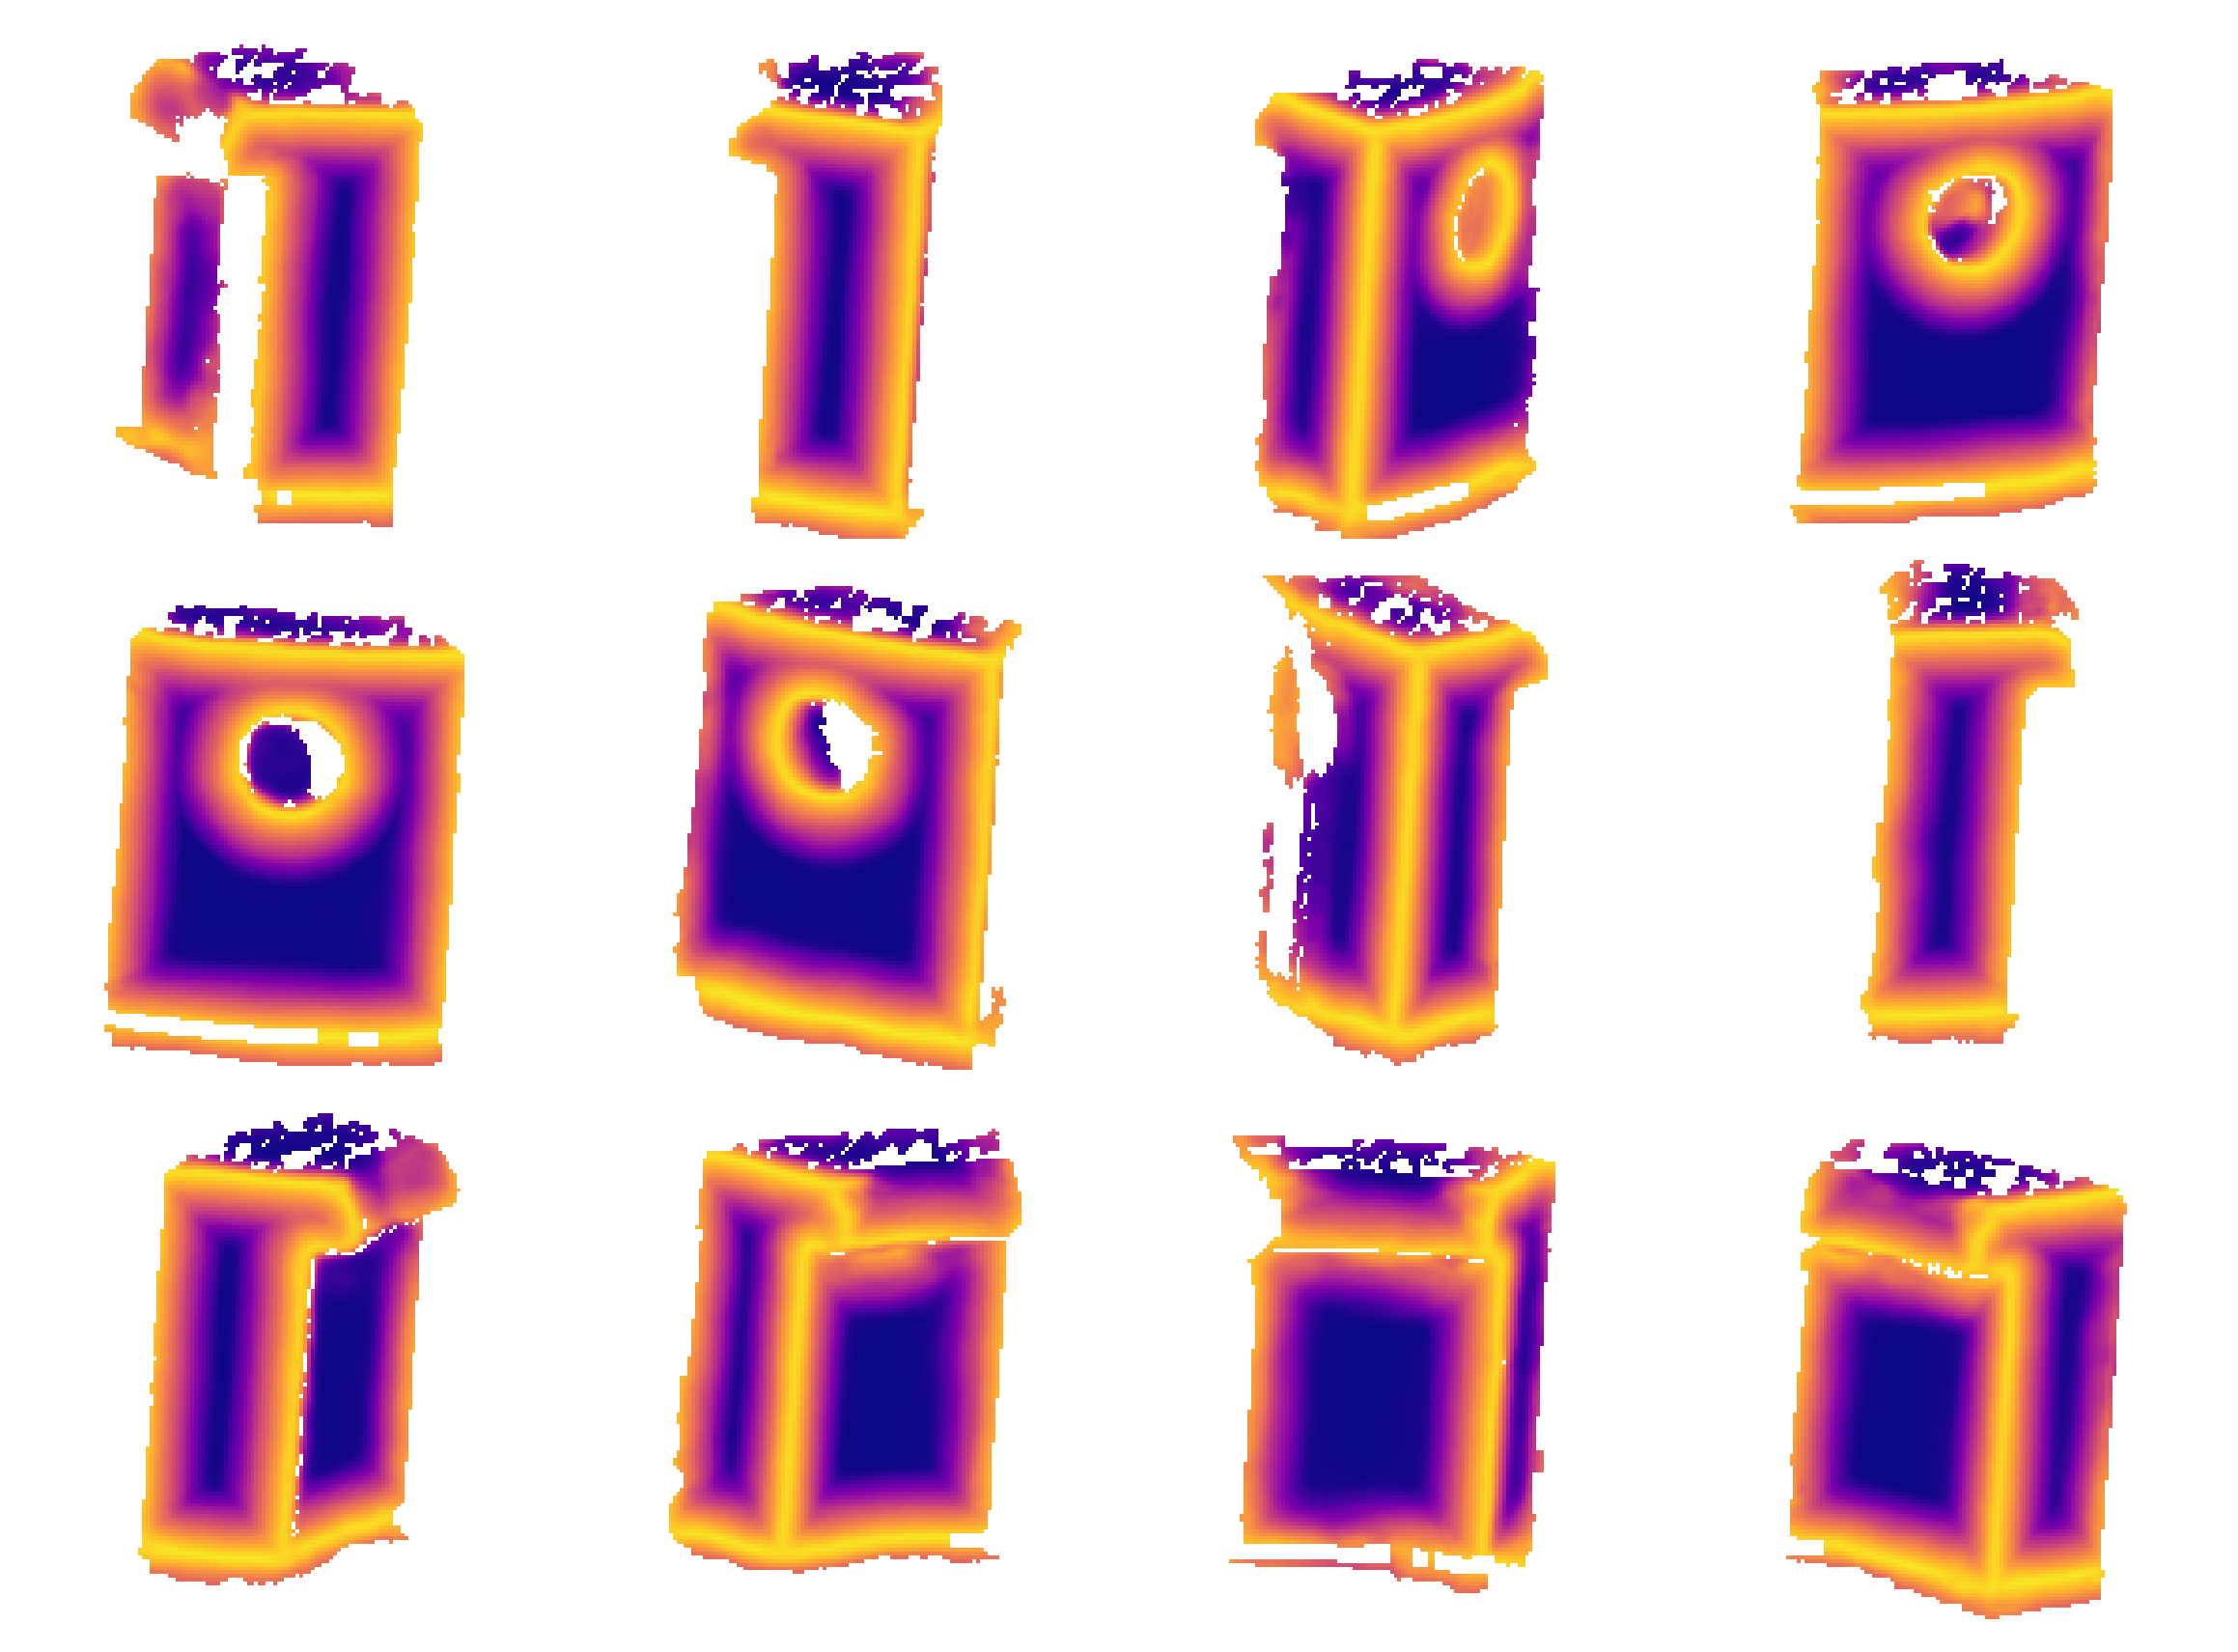

In [314]:
display_depth_sharpness(
#     depth_images=depth_images_for_display[5],
    sharpness_images=sharpness_images_for_display,
    ncols=4,
    max_sharpness=10.0,
#     sharpness_bg_value=10.0
)

In [315]:
n_images = len(views)
point_indexes = np.cumsum([
    np.count_nonzero(view.depth) for view in views])

interp_params = {
    'distance_interp_thr': 'auto',
    'nn_set_size': 4,
    'z_distance_threshold': 4.0,
    'interp_ratio_thr': 0.0,
    'boundary_width_to_remove': 0,
    'verbose': False,
}

Interpolating: 100%|██████████| 5473/5473 [00:00<00:00, 6742.57it/s]


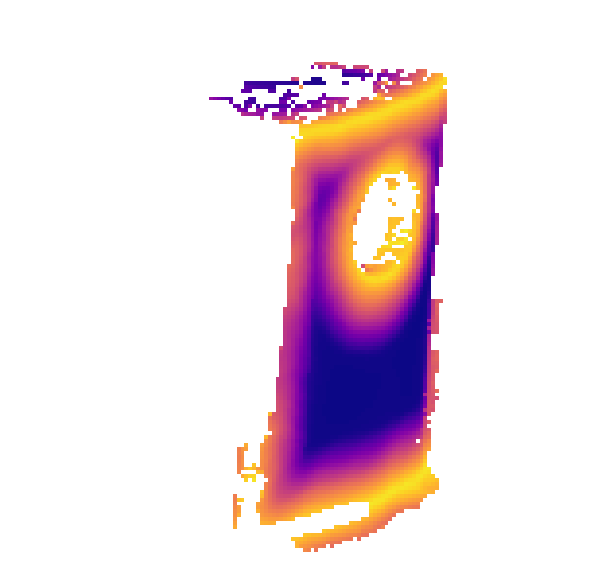

In [317]:
source_view = views_predicted[5]
target_view = views_predicted[2]

import sharpf.fusion.images.pairwise as pairwise
interpolated_view, valid_mask = pairwise.interpolate_views_as_images(
    source_view,
    target_view,
    **interp_params)

interpolated_target_view = target_view.to_points()
interpolated_target_view.depth = interpolated_target_view.depth[valid_mask]
interpolated_target_view.signal = interpolated_view.signal[valid_mask]
interpolated_target_view.to_pixels(inplace=True)

display_depth_sharpness(
#     depth_images=interpolated_target_view.to_pixels().depth[slices[5]],
    sharpness_images=interpolated_target_view.to_pixels().signal[slices[2]],
    max_sharpness=10.0,
#     sharpness_bg_value=10.0
)

In [328]:
list_predictions, list_indexes_in_whole, list_points = [], [], []

for source_view_idx in range(12):
    target_view_idx = 5
    source_view = views_predicted[source_view_idx]
    target_view = views_predicted[target_view_idx]
    
    n_points = len(target_view.to_points().depth)
    target_indexes = np.arange(0, n_points)

    import sharpf.fusion.images.pairwise as pairwise
    interpolated_view, valid_mask = pairwise.interpolate_views_as_images(
        source_view,
        target_view,
        **interp_params)

    interpolated_target_view = target_view.to_points()
    interpolated_target_view.depth = interpolated_target_view.depth[valid_mask]
    interpolated_target_view.signal = interpolated_view.signal[valid_mask]
#     interpolated_target_view.to_pixels(inplace=True)
    list_predictions.append(interpolated_target_view.signal)
    list_indexes_in_whole.append(target_indexes[valid_mask])
    list_points.append(interpolated_target_view.depth)

Interpolating: 100%|██████████| 398/398 [00:00<00:00, 8080.26it/s]


In [329]:
combiner = combiners.TruncatedAvgPredictionsCombiner(func=combiners.TruncatedMean(0.8, func=np.min))
# combiner = combiners.MinPredictionsCombiner()
# combiner = combiners.AvgPredictionsCombiner()
# combiner = combiners.SmoothingCombiner(
#  combiner=combiners.MinPredictionsCombiner(),
#  smoother=smoothers.RobustLocalLinearFit(
#      lm.HuberRegressor(epsilon=4., alpha=1.),
#      n_jobs=32,
#      n_neighbours=9)
# )

fused_points_pred, fused_distances_pred, _ = combiner(
    n_points,
    list_predictions,
    list_indexes_in_whole,
    list_points,
    max_distance=10.0)

12it [00:00, 502.14it/s]
100%|██████████| 9179/9179 [00:02<00:00, 3207.39it/s]


In [330]:
interpolated_target_view = target_view.to_points()
interpolated_target_view.depth = fused_points_pred
interpolated_target_view.signal = fused_distances_pred

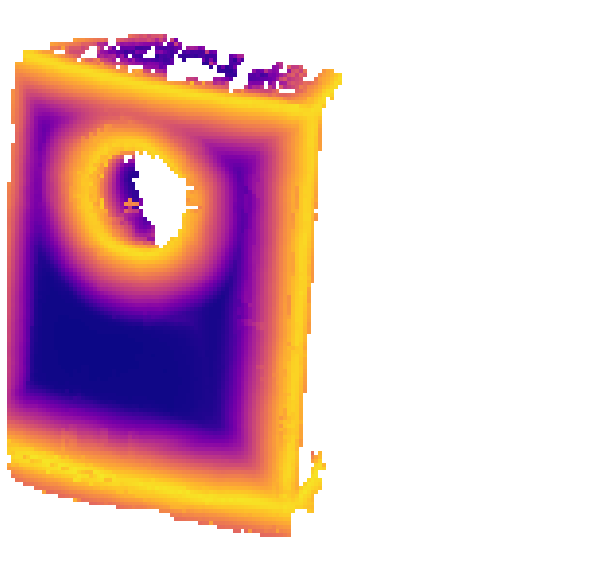

In [331]:
display_depth_sharpness(
#     depth_images=interpolated_target_view.to_pixels().depth[slices[5]],
    sharpness_images=interpolated_target_view.to_pixels().signal[slices[2]],
    max_sharpness=10.0,
#     sharpness_bg_value=10.0
)

In [137]:
obj_filename = '/data/realworld_sharpf_scans/SharpF_200_97_105/100side_folder/00515956_654ec074c8d83a0b57e46110_trimesh_004.obj'

with open(obj_filename, 'rb') as obj_file:
    obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))
    
obj_alignment_transform = ground_truth_dataset[0]['obj_alignment']
obj_scale = ground_truth_dataset[0]['obj_scale']
mesh = obj_mesh.copy() \
    .apply_scale(obj_scale) \
    .apply_transform(obj_alignment_transform)

_ = trimesh.exchange.export.export_mesh(
    mesh,
    '/logs/inference__00515956_654ec074c8d83a0b57e46110_trimesh_004__mesh.obj',
    'obj')

In [138]:
def get_edges(mesh, features):
    curve_segments = []
    for curve_id, curve in enumerate(features['curves']):
        if curve['sharp']:
            # (n, 2) mask of boolean variables where each variable stores
            # True if the corresponding vertex idx is in curve
            is_edgevert_in_curve = np.isin(mesh.edges_unique, curve['vert_indices'])
            is_edge_in_curve = np.all(is_edgevert_in_curve, axis=1)
            edge_in_curve_indexes = np.where(is_edge_in_curve)[0]
            curve_edges = mesh.edges_unique[edge_in_curve_indexes]  # n_curve, 2
            curve_segment_xyz = mesh.vertices[curve_edges]  # n_curve, 2, 3
            curve_segments.append((curve_id, curve['type'], np.ravel(curve_segment_xyz)))

    return curve_segments


def export_features_to_obj(output_filename, curve_segments):
    with open(output_filename, 'w') as fobj:
        vertices = ''
        indices = ''
        max_vi = 1
        for curve_id, curve_type, xyz_xyz in curve_segments:
            xyz_xyz = xyz_xyz.reshape((-1, 2, 3))
            for v1, v2 in xyz_xyz:
                vertices += 'v {v1}\nv {v2}\n'.format(
                    v1=' '.join([str(coord) for coord in v1]),
                    v2=' '.join([str(coord) for coord in v2])
                )
            for edge_idx, edge in enumerate(xyz_xyz):
                indices += 'l {i1} {i2}\n'.format(
                    i1=str(max_vi + edge_idx * 2),
                    i2=str(max_vi + edge_idx * 2 + 1),
                )
            max_vi += 2 * len(xyz_xyz)
        fobj.write(vertices + '\n' + indices)
        

yml_filename = '/data/realworld_sharpf_scans/SharpF_200_97_105/100side_folder/00515956_654ec074c8d83a0b57e46110_features_004.yml'

with open(yml_filename, 'rb') as yml_file:
    yml_features = yaml.load(BytesIO(yml_file.read()), Loader=yaml.Loader)
    
curve_segments = get_edges(mesh, yml_features)
export_features_to_obj(
    '/logs/inference__00515956_654ec074c8d83a0b57e46110_trimesh_004__parametric_gt.obj', 
    curve_segments)

In [147]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)


    
def export_points_to_npy(
    filename, 
    points, 
    distances=None, 
    pose=None, 
    radius=0.02,
    max_distance=1.0):
    
    tol = 1e-3
    if distances is None:
        if pose is not None:
            distances = np.linalg.norm(pose.frame_origin - points, axis=1)        
            helper = MplColorHelper(
                'viridis',
                np.min(distances) - tol,
                np.max(distances) + tol)
        else:
            raise ValueError()
    else:
        helper = MplColorHelper(
            'plasma_r',
            -tol,
            max_distance + tol)

    iterable = zip(points, distances)
    colors_rgb = []
    for point, distance in iterable:
        rgba = helper.get_rgb(distance)
        colors_rgb.append(rgba[:3])
        
    np.save(filename, np.hstack((points, colors_rgb)))
    print('saved {}'.format(filename))

In [149]:
export_points_to_npy(
    '/logs/inference__image_2.npy', 
    views[2].to_points().depth, 
    pose=views[2].pose)

export_points_to_npy(
    '/logs/inference__image_5.npy', 
    views[5].to_points().depth, 
    pose=views[5].pose)

saved /logs/inference__image_2.npy
saved /logs/inference__image_5.npy


In [335]:
_ = display_sharpness(
    mesh,
    samples=np.concatenate((
        views[2].to_points().depth,
        views[5].to_points().depth,
    )),
    samples_psize=1.0
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [68]:
from sharpf.fusion.images.interpolators import MVS_INTERPOLATORS, GroundTruthInterpolator
from sharpf.fusion.images import interpolate

import sharpf.fusion.combiners as combiners
import sharpf.fusion.smoothers as smoothers
import sklearn.linear_model as lm

In [410]:
from skimage.morphology import square, binary_erosion


def remove_boundary_by_erosion(
    image, 
    boundary_width=1,
):
    """For a grayscale image, run binary_erosion and return an image 
    with remaining pixels set to """
    s = square(boundary_width * 2 + 1)
    binary_image = (image != 0).astype(np.int)
    eroded = binary_erosion(binary_image, s)
    output_image = np.zeros_like(image)
    output_image[eroded] = image[eroded]
    return output_image
    

In [432]:
views_predicted = [view.copy() for view in views]
views_predicted = [view.to_pixels() for view in views_predicted]
for distances, view in zip(list_distances_pred, views_predicted):
    view.signal = distances

In [433]:
boundary_width = 7

for view in views_predicted:
    view.depth = remove_boundary_by_erosion(view.depth, boundary_width)
    view.signal = remove_boundary_by_erosion(view.signal, boundary_width)

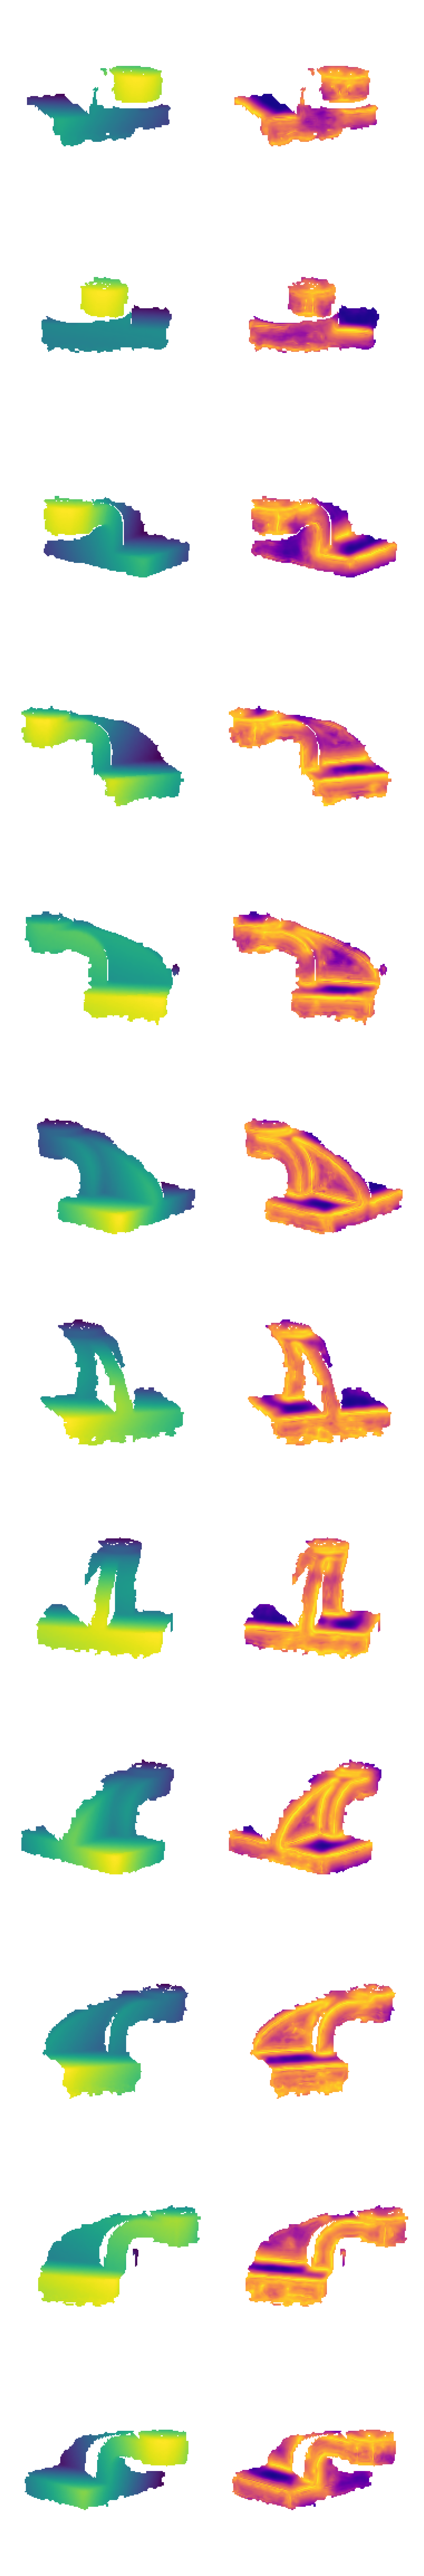

In [115]:
sx, sy = 192, 192

depth_images_for_display = []
sharpness_images_for_display = []
for view in views_predicted:
    image = clip_to_depth(
        view.to_pixels().depth, 
        view.to_pixels().depth, 
        depth_value=0.0)
    distances = clip_to_depth(
        view.to_pixels().signal, 
        view.to_pixels().depth, 
        depth_value=0.0) 
    distances, offset = crop_around_center(distances, (sx, sy))
    sharpness_images_for_display.append(distances)
    depth_images_for_display.append(
        image[offset[0]:offset[0] + sy, offset[1]:offset[1] + sx])

display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=sharpness_images_for_display,
    ncols=1,
    axes_size=(16, 16),
    bgcolor='white',
    max_sharpness=1.0)

In [194]:
views_reprojected = []
views_reprojected_source = []

n_images = 12
for i, j in tqdm(itertools.product(range(n_images), range(n_images))):
    if i == j:
        views_reprojected.append(source_view)
        views_reprojected_source.append(source_view)
        
    else:
        source_view = views_predicted[i].to_image()
        target_view_r = views_predicted[j].reproject_to(source_view)
        print(i, j, 
              target_view_r.pose.camera_to_world_4x4, 
              views_predicted[j].pose.camera_to_world_4x4, 
              source_view.pose.camera_to_world_4x4)
        
        target_signal, valid_mask = interpolate.pointwise_interpolate_image(
            source_view.depth,
            source_view.signal,
            target_view_r.depth,
            distance_interp_thr='auto',
            nn_set_size=8,
            z_distance_threshold=4.0,
            verbose=False)
        
        target_view_interp = target_view_r.copy()
        target_view_interp.depth = target_view_interp.depth[valid_mask]
        target_view_interp.signal = target_signal[valid_mask]

        views_reprojected.append(target_view_interp)
#         print(target_view_interp.pose.camera_to_world_4x4- 
#              target_view_interp.reproject_to(views_predicted[j]).pose.camera_to_world_4x4)
        views_reprojected_source.append(
            target_view_interp.reproject_to(views_predicted[j]))
        


Interpolating:  12%|█▏        | 467/3807 [00:00<00:00, 4660.76it/s]

0 1 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



Interpolating: 100%|██████████| 3807/3807 [00:00<00:00, 5528.67it/s]

Interpolating:   0%|          | 0/2736 [00:00<?, ?it/s]

[[-3.60852605e-02 -9.96060323e-02  3.59076719e-01 -7.08698277e+02]
 [-1.41874134e-01  8.22870875e-02 -3.24449766e-01  6.31957706e+02]
 [ 4.83646799e-01  3.84240944e-02 -6.24555593e-02  1.45974290e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 2 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93


Interpolating: 100%|██████████| 2736/2736 [00:00<00:00, 6670.18it/s]

Interpolating:   0%|          | 0/884 [00:00<?, ?it/s]

[[ 1.30006726e-01 -1.89521252e-01  7.10856890e-01 -1.39330227e+03]
 [-4.52755944e-01  1.31328705e-01 -5.50254135e-01  1.06167805e+03]
 [ 8.90548927e-01  1.40708070e-01 -3.70817468e-01  7.72379368e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 3 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93


Interpolating: 100%|██████████| 884/884 [00:00<00:00, 6854.29it/s]

Interpolating: 100%|██████████| 506/506 [00:00<00:00, 7568.33it/s]

[[ 4.43146155e-01 -2.33998914e-01  9.23953814e-01 -1.79789259e+03]
 [-8.18543869e-01  1.27046329e-01 -5.92300262e-01  1.12703700e+03]
 [ 1.06835895e+00  2.69494950e-01 -8.16485056e-01  1.65829708e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 4 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93



Interpolating:   0%|          | 0/574 [00:00<?, ?it/s]

[[ 8.43431851e-01 -2.26407047e-01  9.56794843e-01 -1.84338805e+03]
 [-1.17103808e+00  7.13100046e-02 -4.40748179e-01  8.11771611e+02]
 [ 9.81422665e-01  4.01358006e-01 -1.31484805e+00  2.63543925e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 5 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93

Interpolating: 100%|██████████| 574/574 [00:00<00:00, 6432.14it/s]

Interpolating:   0%|          | 0/921 [00:00<?, ?it/s]

[[ 1.18627548e+00 -1.68345392e-01  7.95907225e-01 -1.51029443e+03]
 [-1.38264621e+00 -1.68201488e-02 -1.49798415e-01  2.28879751e+02]
 [ 6.59207576e-01  4.89261957e-01 -1.68577473e+00  3.35036999e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 6 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93


Interpolating: 100%|██████████| 921/921 [00:00<00:00, 6009.49it/s]

Interpolating:   0%|          | 0/1075 [00:00<?, ?it/s]

[[ 1.40222239e+00 -7.19648099e-02  4.77743129e-01 -8.73728386e+02]
 [-1.41265076e+00 -1.18916850e-01  2.18094772e-01 -4.96781847e+02]
 [ 1.72003226e-01  5.15123441e-01 -1.85579699e+00  3.66176810e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 7 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93


Interpolating: 100%|██████████| 1075/1075 [00:00<00:00, 6700.02it/s][A

Interpolating:   0%|          | 0/1607 [00:00<?, ?it/s]

[[ 1.41675390e+00  3.30152944e-02  9.44694145e-02 -1.18442077e+02]
 [-1.24094868e+00 -2.02099404e-01  5.50904611e-01 -1.14390468e+03]
 [-3.34320322e-01  4.67171536e-01 -1.76013005e+00  3.44927235e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 8 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93


Interpolating: 100%|██████████| 1607/1607 [00:00<00:00, 7568.85it/s]

Interpolating:   0%|          | 0/2221 [00:00<?, ?it/s]

[[ 1.23312084e+00  1.14621564e-01 -2.34656688e-01  5.20703721e+02]
 [-9.28063126e-01 -2.42638887e-01  7.49111873e-01 -1.51921206e+03]
 [-7.05519582e-01  3.63877980e-01 -1.43805393e+00  2.79760915e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 9 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93


Interpolating: 100%|██████████| 2221/2221 [00:00<00:00, 7723.29it/s]

Interpolating:   0%|          | 0/2921 [00:00<?, ?it/s]

[[ 8.95692189e-01  1.54185529e-01 -4.35438735e-01  8.99944038e+02]
 [-5.47431433e-01 -2.31005080e-01  7.67880222e-01 -1.53801787e+03]
 [-8.57683173e-01  2.29440345e-01 -9.66390955e-01  1.86178098e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 10 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.9


Interpolating: 100%|██████████| 2921/2921 [00:00<00:00, 7304.75it/s]

Interpolating:   0%|          | 0/4195 [00:00<?, ?it/s]

[[ 5.11327346e-01  1.40543415e-01 -4.43144791e-01  8.96769082e+02]
 [-2.22352214e-01 -1.72569446e-01  6.04420692e-01 -1.20059861e+03]
 [-7.44976908e-01  1.04378658e-01 -4.96361330e-01  9.41697966e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
0 11 [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.9


Interpolating: 100%|██████████| 4195/4195 [00:00<00:00, 6832.23it/s]

Interpolating:   0%|          | 0/3712 [00:00<?, ?it/s]

[[ 1.65706735e-01  7.44609342e-02 -2.54709514e-01  5.09323176e+02]
 [-2.10660347e-02 -7.83281443e-02  2.89364379e-01 -5.70700855e+02]
 [-3.86101162e-01  2.02059495e-02 -1.29398985e-01  2.36279371e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 0 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78


Interpolating: 100%|██████████| 3712/3712 [00:00<00:00, 6774.08it/s]

Interpolating:   0%|          | 0/3652 [00:00<?, ?it/s]

[[ 3.60852605e-02  9.96060323e-02 -3.59076719e-01  7.08698277e+02]
 [ 1.41874134e-01 -8.22870875e-02  3.24449766e-01 -6.31957706e+02]
 [-4.83646799e-01 -3.84240944e-02  6.24555593e-02 -1.45974290e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 2 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78


Interpolating: 100%|██████████| 3652/3652 [00:00<00:00, 6327.78it/s]

Interpolating:   0%|          | 0/1854 [00:00<?, ?it/s]

[[ 1.66091987e-01 -8.99152201e-02  3.51780171e-01 -6.84603991e+02]
 [-3.10881810e-01  4.90416173e-02 -2.25804369e-01  4.29720341e+02]
 [ 4.06902127e-01  1.02283975e-01 -3.08361909e-01  6.26405077e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 3 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78


Interpolating: 100%|██████████| 1854/1854 [00:00<00:00, 6446.69it/s]

Interpolating:   0%|          | 0/1421 [00:00<?, ?it/s]

[[ 4.79231416e-01 -1.34392882e-01  5.64877096e-01 -1.08919431e+03]
 [-6.76669736e-01  4.47592420e-02 -2.67850496e-01  4.95079298e+02]
 [ 5.84712154e-01  2.31070856e-01 -7.54029496e-01  1.51232279e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 4 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78


Interpolating: 100%|██████████| 1421/1421 [00:00<00:00, 6778.49it/s]

Interpolating:   0%|          | 0/1131 [00:00<?, ?it/s]

[[ 8.79517112e-01 -1.26801015e-01  5.97718125e-01 -1.13468977e+03]
 [-1.02916395e+00 -1.09770828e-02 -1.16298414e-01  1.79813905e+02]
 [ 4.97775866e-01  3.62933912e-01 -1.25239249e+00  2.48946496e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 5 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78


Interpolating: 100%|██████████| 1131/1131 [00:00<00:00, 6385.35it/s][A

Interpolating:   0%|          | 0/1039 [00:00<?, ?it/s]

[[ 1.22236075e+00 -6.87393596e-02  4.36830507e-01 -8.01596155e+02]
 [-1.24077208e+00 -9.91072362e-02  1.74651350e-01 -4.03077955e+02]
 [ 1.75560777e-01  4.50837862e-01 -1.62331917e+00  3.20439570e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 6 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78


Interpolating: 100%|██████████| 1039/1039 [00:00<00:00, 6544.37it/s][A

Interpolating:   0%|          | 0/862 [00:00<?, ?it/s]

[[ 1.43830765e+00  2.76412224e-02  1.18666410e-01 -1.65030109e+02]
 [-1.27077663e+00 -2.01203937e-01  5.42544538e-01 -1.12873955e+03]
 [-3.11643574e-01  4.76699346e-01 -1.79334143e+00  3.51579380e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 7 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78


Interpolating: 100%|██████████| 862/862 [00:00<00:00, 6466.39it/s]

Interpolating:   0%|          | 0/486 [00:00<?, ?it/s]

[[ 1.45283916e+00  1.32621327e-01 -2.64607304e-01  5.90256200e+02]
 [-1.09907454e+00 -2.84386492e-01  8.75354376e-01 -1.77586239e+03]
 [-8.17967122e-01  4.28747441e-01 -1.69767449e+00  3.30329806e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 8 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78

Interpolating: 100%|██████████| 486/486 [00:00<00:00, 6823.70it/s]

Interpolating:   0%|          | 0/516 [00:00<?, ?it/s]

[[ 1.26920610e+00  2.14227596e-01 -5.93733406e-01  1.22940200e+03]
 [-7.86188992e-01 -3.24925974e-01  1.07356164e+00 -2.15116977e+03]
 [-1.18916638e+00  3.25453886e-01 -1.37559837e+00  2.65163486e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 9 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78

Interpolating: 100%|██████████| 516/516 [00:00<00:00, 7360.53it/s]

Interpolating:   0%|          | 0/1044 [00:00<?, ?it/s]

[[ 9.31777450e-01  2.53791561e-01 -7.94515453e-01  1.60864232e+03]
 [-4.05557299e-01 -3.13292168e-01  1.09232999e+00 -2.16997557e+03]
 [-1.34132997e+00  1.91016250e-01 -9.03935396e-01  1.71580669e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 10 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.7


Interpolating: 100%|██████████| 1044/1044 [00:00<00:00, 7758.61it/s][A

Interpolating:   0%|          | 0/2468 [00:00<?, ?it/s]


[[ 5.47412607e-01  2.40149447e-01 -8.02221510e-01  1.60546736e+03]
 [-8.04780801e-02 -2.54856533e-01  9.28870458e-01 -1.83255632e+03]
 [-1.22862371e+00  6.59545640e-02 -4.33905771e-01  7.95723675e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
1 11 [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.7

Interpolating: 100%|██████████| 2468/2468 [00:00<00:00, 6581.68it/s]

Interpolating:   0%|          | 0/3277 [00:00<?, ?it/s]

[[ 2.01791996e-01  1.74066966e-01 -6.13786232e-01  1.21802145e+03]
 [ 1.20808099e-01 -1.60615232e-01  6.13814144e-01 -1.20265856e+03]
 [-8.69747962e-01 -1.82181449e-02 -6.69434256e-02  9.03050809e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 0 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 3277/3277 [00:00<00:00, 7368.34it/s]

Interpolating:   0%|          | 0/4365 [00:00<?, ?it/s]

[[-1.30006726e-01  1.89521252e-01 -7.10856890e-01  1.39330227e+03]
 [ 4.52755944e-01 -1.31328705e-01  5.50254135e-01 -1.06167805e+03]
 [-8.90548927e-01 -1.40708070e-01  3.70817468e-01 -7.72379368e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 1 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 4365/4365 [00:00<00:00, 6875.64it/s]

Interpolating:   0%|          | 0/5213 [00:00<?, ?it/s]

[[-1.66091987e-01  8.99152201e-02 -3.51780171e-01  6.84603991e+02]
 [ 3.10881810e-01 -4.90416173e-02  2.25804369e-01 -4.29720341e+02]
 [-4.06902127e-01 -1.02283975e-01  3.08361909e-01 -6.26405077e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 3 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 5213/5213 [00:00<00:00, 6236.61it/s]

Interpolating:   0%|          | 0/5164 [00:00<?, ?it/s]

[[ 3.13139429e-01 -4.44776615e-02  2.13096924e-01 -4.04590324e+02]
 [-3.65787926e-01 -4.28237528e-03 -4.20461273e-02  6.53589566e+01]
 [ 1.77810026e-01  1.28786881e-01 -4.45667587e-01  8.85917710e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 4 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 5164/5164 [00:00<00:00, 6496.09it/s]

Interpolating:   0%|          | 0/4111 [00:00<?, ?it/s]

[[ 7.13425125e-01 -3.68857946e-02  2.45937953e-01 -4.50085783e+02]
 [-7.18282137e-01 -6.00187001e-02  1.09505955e-01 -2.49906436e+02]
 [ 9.08737386e-02  2.60649936e-01 -9.44030578e-01  1.86305988e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 5 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 4111/4111 [00:00<00:00, 5480.52it/s]

Interpolating:   0%|          | 0/1547 [00:00<?, ?it/s]

[[ 1.05626876e+00  2.11758605e-02  8.50503355e-02 -1.16992164e+02]
 [-9.29890268e-01 -1.48148854e-01  4.00455719e-01 -8.32798296e+02]
 [-2.31341350e-01  3.48553887e-01 -1.31495727e+00  2.57799062e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 6 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 1547/1547 [00:00<00:00, 6559.81it/s]

Interpolating:   0%|          | 0/950 [00:00<?, ?it/s]

[[ 1.27221567e+00  1.17556442e-01 -2.33113761e-01  5.19573882e+02]
 [-9.59894816e-01 -2.50245555e-01  7.68348907e-01 -1.55845989e+03]
 [-7.18545701e-01  3.74415371e-01 -1.48497953e+00  2.88938873e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 7 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 950/950 [00:00<00:00, 6070.09it/s]

Interpolating: 100%|██████████| 468/468 [00:00<00:00, 6414.94it/s]

[[ 1.28674718e+00  2.22536547e-01 -6.16387475e-01  1.27486019e+03]
 [-7.88192733e-01 -3.33428109e-01  1.10115875e+00 -2.20558273e+03]
 [-1.22486925e+00  3.26463466e-01 -1.38931258e+00  2.67689298e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 8 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16



Interpolating: 100%|██████████| 252/252 [00:00<00:00, 7310.28it/s]


[[ 1.10311411e+00  3.04142817e-01 -9.45513578e-01  1.91400599e+03]
 [-4.75307182e-01 -3.73967592e-01  1.29936601e+00 -2.58089011e+03]
 [-1.59606851e+00  2.23169911e-01 -1.06723646e+00  2.02522978e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
2 9 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16


Interpolating: 100%|██████████| 566/566 [00:00<00:00, 8045.90it/s]

2 10 [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 3.81320620e-01  3.30064667e-01 -1.15400168e+00  2.29007135e+03]
 [ 2.30403730e-01 -3.03898151e-01  1.15467483e+00 -2.26227666e+03]
 [-1.63552583e+00 -3.63294112e-02 -1.25543862e-01  1.6



Interpolating: 100%|██████████| 2022/2022 [00:00<00:00, 6561.60it/s]

Interpolating:   0%|          | 0/1004 [00:00<?, ?it/s]

[[ 3.57000087e-02  2.63982187e-01 -9.65566404e-01  1.90262544e+03]
 [ 4.31689909e-01 -2.09656849e-01  8.39618513e-01 -1.63237890e+03]
 [-1.27665009e+00 -1.20502120e-01  2.41418484e-01 -5.36099996e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 0 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 1004/1004 [00:00<00:00, 7262.83it/s][A

Interpolating:   0%|          | 0/2054 [00:00<?, ?it/s]

[[-4.43146155e-01  2.33998914e-01 -9.23953814e-01  1.79789259e+03]
 [ 8.18543869e-01 -1.27046329e-01  5.92300262e-01 -1.12703700e+03]
 [-1.06835895e+00 -2.69494950e-01  8.16485056e-01 -1.65829708e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 1 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 2054/2054 [00:00<00:00, 6925.77it/s]

Interpolating:   0%|          | 0/4455 [00:00<?, ?it/s]

[[-4.79231416e-01  1.34392882e-01 -5.64877096e-01  1.08919431e+03]
 [ 6.76669736e-01 -4.47592420e-02  2.67850496e-01 -4.95079298e+02]
 [-5.84712154e-01 -2.31070856e-01  7.54029496e-01 -1.51232279e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 2 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 4455/4455 [00:00<00:00, 6646.55it/s]

Interpolating:   0%|          | 0/6170 [00:00<?, ?it/s]

[[-3.13139429e-01  4.44776615e-02 -2.13096924e-01  4.04590324e+02]
 [ 3.65787926e-01  4.28237528e-03  4.20461273e-02 -6.53589566e+01]
 [-1.77810026e-01 -1.28786881e-01  4.45667587e-01 -8.85917710e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 4 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 6170/6170 [00:00<00:00, 6464.02it/s]

Interpolating:   0%|          | 0/5108 [00:00<?, ?it/s]

[[ 4.00285696e-01  7.59186690e-03  3.28410292e-02 -4.54954590e+01]
 [-3.52494211e-01 -5.57363248e-02  1.51552083e-01 -3.15265393e+02]
 [-8.69362878e-02  1.31863056e-01 -4.98362991e-01  9.77142175e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 5 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 5108/5108 [00:00<00:00, 6503.65it/s]

Interpolating:   0%|          | 0/2113 [00:00<?, ?it/s]

[[ 7.43129330e-01  6.56535220e-02 -1.28046589e-01  2.87598160e+02]
 [-5.64102342e-01 -1.43866478e-01  4.42501846e-01 -8.98157253e+02]
 [-4.09151377e-01  2.19767006e-01 -8.69289678e-01  1.69207291e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 6 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 2113/2113 [00:00<00:00, 6559.02it/s]

Interpolating:   0%|          | 0/1354 [00:00<?, ?it/s]

[[ 9.59076238e-01  1.62034104e-01 -4.46210686e-01  9.24164206e+02]
 [-5.94106891e-01 -2.45963179e-01  8.10395034e-01 -1.62381885e+03]
 [-8.96355727e-01  2.45628490e-01 -1.03931194e+00  2.00347102e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 7 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 1354/1354 [00:00<00:00, 6846.23it/s][A

Interpolating:   0%|          | 0/706 [00:00<?, ?it/s]

[[ 9.73607749e-01  2.67014208e-01 -8.29484400e-01  1.67945052e+03]
 [-4.22404807e-01 -3.29145734e-01  1.14320487e+00 -2.27094168e+03]
 [-1.40267928e+00  1.97676585e-01 -9.43644995e-01  1.79097527e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 8 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 706/706 [00:00<00:00, 6003.42it/s]

Interpolating: 100%|██████████| 316/316 [00:00<00:00, 6697.86it/s]


[[ 7.89974685e-01  3.48620478e-01 -1.15861050e+00  2.31859631e+03]
 [-1.09519256e-01 -3.69685216e-01  1.34141213e+00 -2.64624907e+03]
 [-1.77387854e+00  9.43830301e-02 -6.21568871e-01  1.13931207e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
3 9 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74


Interpolating: 100%|██████████| 345/345 [00:00<00:00, 6819.72it/s]

3 10 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 6.81811913e-02  3.74542329e-01 -1.36709861e+00  2.69466167e+03]
 [ 5.96191656e-01 -2.99615775e-01  1.19672095e+00 -2.32763562e+03]
 [-1.81333586e+00 -1.65116292e-01  3.20123725e-01 -7.1



Interpolating: 100%|██████████| 619/619 [00:00<00:00, 7708.77it/s]

3 11 [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-2.77439420e-01  3.08459848e-01 -1.17866333e+00  2.30721577e+03]
 [ 7.97477835e-01 -2.05374474e-01  8.81664641e-01 -1.69773786e+03]
 [-1.45446012e+00 -2.49289001e-01  6.87086071e-01 -1.4



Interpolating: 100%|██████████| 537/537 [00:00<00:00, 7574.05it/s]

4 0 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-8.43431851e-01  2.26407047e-01 -9.56794843e-01  1.84338805e+03]
 [ 1.17103808e+00 -7.13100046e-02  4.40748179e-01 -8.11771611e+02]
 [-9.81422665e-01 -4.01358006e-01  1.31484805e+00 -2.63



Interpolating:  50%|████▉     | 723/1455 [00:00<00:00, 7219.01it/s]

4 1 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



Interpolating: 100%|██████████| 1455/1455 [00:00<00:00, 6908.66it/s]

Interpolating:   0%|          | 0/3888 [00:00<?, ?it/s]

[[-8.79517112e-01  1.26801015e-01 -5.97718125e-01  1.13468977e+03]
 [ 1.02916395e+00  1.09770828e-02  1.16298414e-01 -1.79813905e+02]
 [-4.97775866e-01 -3.62933912e-01  1.25239249e+00 -2.48946496e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 2 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02


Interpolating: 100%|██████████| 3888/3888 [00:00<00:00, 6491.76it/s]

Interpolating:   0%|          | 0/5909 [00:00<?, ?it/s]

[[-7.13425125e-01  3.68857946e-02 -2.45937953e-01  4.50085783e+02]
 [ 7.18282137e-01  6.00187001e-02 -1.09505955e-01  2.49906436e+02]
 [-9.08737386e-02 -2.60649936e-01  9.44030578e-01 -1.86305988e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 3 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02


Interpolating: 100%|██████████| 5909/5909 [00:00<00:00, 5982.65it/s]

Interpolating:   0%|          | 0/6212 [00:00<?, ?it/s]

[[-4.00285696e-01 -7.59186690e-03 -3.28410292e-02  4.54954590e+01]
 [ 3.52494211e-01  5.57363248e-02 -1.51552083e-01  3.15265393e+02]
 [ 8.69362878e-02 -1.31863056e-01  4.98362991e-01 -9.77142175e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 5 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02


Interpolating: 100%|██████████| 6212/6212 [00:01<00:00, 6003.33it/s]

Interpolating:   0%|          | 0/3317 [00:00<?, ?it/s]

[[ 3.42843633e-01  5.80616551e-02 -1.60887618e-01  3.33093619e+02]
 [-2.11608131e-01 -8.81301534e-02  2.90949764e-01 -5.82891860e+02]
 [-3.22215089e-01  8.79039507e-02 -3.70926687e-01  7.14930736e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 6 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02


Interpolating: 100%|██████████| 3317/3317 [00:00<00:00, 6271.31it/s]

Interpolating:   0%|          | 0/2181 [00:00<?, ?it/s]

[[ 5.58790542e-01  1.54442237e-01 -4.79051715e-01  9.69659665e+02]
 [-2.41612680e-01 -1.90226854e-01  6.58842951e-01 -1.30855346e+03]
 [-8.09419439e-01  1.13765435e-01 -5.40948947e-01  1.02632884e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 7 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02


Interpolating: 100%|██████████| 2181/2181 [00:00<00:00, 6324.73it/s]

Interpolating:   0%|          | 0/1279 [00:00<?, ?it/s]

[[ 5.73322053e-01  2.59422341e-01 -8.62325429e-01  1.72494597e+03]
 [-6.99105965e-02 -2.73409409e-01  9.91652790e-01 -1.95567629e+03]
 [-1.31574299e+00  6.58135297e-02 -4.45282004e-01  8.13833100e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 8 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02


Interpolating: 100%|██████████| 1279/1279 [00:00<00:00, 6671.00it/s][A

Interpolating:   0%|          | 0/600 [00:00<?, ?it/s]

[[ 3.89688989e-01  3.41028611e-01 -1.19145153e+00  2.36409177e+03]
 [ 2.42974955e-01 -3.13948891e-01  1.18986005e+00 -2.33098368e+03]
 [-1.68694225e+00 -3.74800256e-02 -1.23205880e-01  1.62169899e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 9 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02

Interpolating: 100%|██████████| 600/600 [00:00<00:00, 6447.49it/s]

Interpolating:   0%|          | 0/410 [00:00<?, ?it/s]

[[ 5.22603380e-02  3.80592576e-01 -1.39223358e+00  2.74333209e+03]
 [ 6.23606647e-01 -3.02315085e-01  1.20862840e+00 -2.34978948e+03]
 [-1.83910584e+00 -1.71917661e-01  3.48457092e-01 -7.73658268e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 10 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.0

Interpolating: 100%|██████████| 410/410 [00:00<00:00, 5904.04it/s]

Interpolating: 100%|██████████| 352/352 [00:00<00:00, 6377.24it/s]

[[-3.32104505e-01  3.66950462e-01 -1.39993963e+00  2.74015713e+03]
 [ 9.48685866e-01 -2.43879450e-01  1.04516887e+00 -2.01237022e+03]
 [-1.72639957e+00 -2.96979348e-01  8.18486716e-01 -1.69374129e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
4 11 [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.0



Interpolating:   0%|          | 0/593 [00:00<?, ?it/s]

[[-6.77725116e-01  3.00867981e-01 -1.21150436e+00  2.35271123e+03]
 [ 1.14997205e+00 -1.49638149e-01  7.30112558e-01 -1.38247247e+03]
 [-1.36752383e+00 -3.81152056e-01  1.18544906e+00 -2.39915988e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 0 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 593/593 [00:00<00:00, 5738.56it/s]

Interpolating:   0%|          | 0/1146 [00:00<?, ?it/s]

[[-1.18627548e+00  1.68345392e-01 -7.95907225e-01  1.51029443e+03]
 [ 1.38264621e+00  1.68201488e-02  1.49798415e-01 -2.28879751e+02]
 [-6.59207576e-01 -4.89261957e-01  1.68577473e+00 -3.35036999e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 1 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 1146/1146 [00:00<00:00, 6485.78it/s][A

Interpolating:   0%|          | 0/3521 [00:00<?, ?it/s]

[[-1.22236075e+00  6.87393596e-02 -4.36830507e-01  8.01596155e+02]
 [ 1.24077208e+00  9.91072362e-02 -1.74651350e-01  4.03077955e+02]
 [-1.75560777e-01 -4.50837862e-01  1.62331917e+00 -3.20439570e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 2 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 3521/3521 [00:00<00:00, 6326.14it/s]

Interpolating:   0%|          | 0/5589 [00:00<?, ?it/s]

[[-1.05626876e+00 -2.11758605e-02 -8.50503355e-02  1.16992164e+02]
 [ 9.29890268e-01  1.48148854e-01 -4.00455719e-01  8.32798296e+02]
 [ 2.31341350e-01 -3.48553887e-01  1.31495727e+00 -2.57799062e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 3 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 5589/5589 [00:00<00:00, 6384.18it/s]

Interpolating:   0%|          | 0/6818 [00:00<?, ?it/s]

[[-7.43129330e-01 -6.56535220e-02  1.28046589e-01 -2.87598160e+02]
 [ 5.64102342e-01  1.43866478e-01 -4.42501846e-01  8.98157253e+02]
 [ 4.09151377e-01 -2.19767006e-01  8.69289678e-01 -1.69207291e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 4 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 6818/6818 [00:01<00:00, 6376.27it/s]

Interpolating:   0%|          | 0/5916 [00:00<?, ?it/s]

[[-3.42843633e-01 -5.80616551e-02  1.60887618e-01 -3.33093619e+02]
 [ 2.11608131e-01  8.81301534e-02 -2.90949764e-01  5.82891860e+02]
 [ 3.22215089e-01 -8.79039507e-02  3.70926687e-01 -7.14930736e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 6 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 5916/5916 [00:00<00:00, 6459.44it/s]

Interpolating:   0%|          | 0/4697 [00:00<?, ?it/s]

[[ 2.15946908e-01  9.63805820e-02 -3.18164097e-01  6.36566046e+02]
 [-3.00045487e-02 -1.02096701e-01  3.67893188e-01 -7.25661598e+02]
 [-4.87204351e-01  2.58614840e-02 -1.70022260e-01  3.11398108e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 7 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 4697/4697 [00:00<00:00, 6535.38it/s]

Interpolating:   0%|          | 0/3151 [00:00<?, ?it/s]

[[ 2.30478419e-01  2.01360686e-01 -7.01437811e-01  1.39185236e+03]
 [ 1.41697534e-01 -1.85279256e-01  7.00703026e-01 -1.37278443e+03]
 [-9.93527899e-01 -2.20904210e-02 -7.43553166e-02  9.89023641e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 8 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 3151/3151 [00:00<00:00, 6072.10it/s]

Interpolating:   0%|          | 0/1202 [00:00<?, ?it/s]

[[ 4.68453553e-02  2.82966956e-01 -1.03056391e+00  2.03099815e+03]
 [ 4.54583086e-01 -2.25818738e-01  8.98910289e-01 -1.74809181e+03]
 [-1.36472716e+00 -1.25383976e-01  2.47720807e-01 -5.52760837e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 9 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41


Interpolating: 100%|██████████| 1202/1202 [00:00<00:00, 6521.41it/s][A

Interpolating:   0%|          | 0/805 [00:00<?, ?it/s]

[[-2.90583295e-01  3.22530921e-01 -1.23134596e+00  2.41023847e+03]
 [ 8.35214778e-01 -2.14184931e-01  9.17678637e-01 -1.76689762e+03]
 [-1.51689075e+00 -2.59821612e-01  7.19383779e-01 -1.48858900e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 10 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.4


Interpolating: 100%|██████████| 805/805 [00:00<00:00, 6476.58it/s]

Interpolating:   0%|          | 0/618 [00:00<?, ?it/s]

[[-6.74948138e-01  3.08888807e-01 -1.23905202e+00  2.40706351e+03]
 [ 1.16029400e+00 -1.55749297e-01  7.54219108e-01 -1.42947836e+03]
 [-1.40418448e+00 -3.84883298e-01  1.18941340e+00 -2.40867202e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
5 11 [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.4

Interpolating: 100%|██████████| 618/618 [00:00<00:00, 6566.52it/s]

Interpolating:   0%|          | 0/977 [00:00<?, ?it/s]

[[-1.02056875e+00  2.42806326e-01 -1.05061674e+00  2.01961761e+03]
 [ 1.36158018e+00 -6.15079956e-02  4.39162794e-01 -7.99580606e+02]
 [-1.04530874e+00 -4.69056007e-01  1.55637575e+00 -3.11409062e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 0 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 977/977 [00:00<00:00, 6429.20it/s]

Interpolating:   0%|          | 0/1052 [00:00<?, ?it/s]

[[-1.40222239e+00  7.19648099e-02 -4.77743129e-01  8.73728386e+02]
 [ 1.41265076e+00  1.18916850e-01 -2.18094772e-01  4.96781847e+02]
 [-1.72003226e-01 -5.15123441e-01  1.85579699e+00 -3.66176810e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 1 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 1052/1052 [00:00<00:00, 6225.87it/s][A

Interpolating:   0%|          | 0/2024 [00:00<?, ?it/s]

[[-1.43830765e+00 -2.76412224e-02 -1.18666410e-01  1.65030109e+02]
 [ 1.27077663e+00  2.01203937e-01 -5.42544538e-01  1.12873955e+03]
 [ 3.11643574e-01 -4.76699346e-01  1.79334143e+00 -3.51579380e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 2 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 2024/2024 [00:00<00:00, 6788.23it/s]

Interpolating:   0%|          | 0/3031 [00:00<?, ?it/s]

[[-1.27221567e+00 -1.17556442e-01  2.33113761e-01 -5.19573882e+02]
 [ 9.59894816e-01  2.50245555e-01 -7.68348907e-01  1.55845989e+03]
 [ 7.18545701e-01 -3.74415371e-01  1.48497953e+00 -2.88938873e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 3 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 3031/3031 [00:00<00:00, 7215.44it/s]

Interpolating:   0%|          | 0/4203 [00:00<?, ?it/s]

[[-9.59076238e-01 -1.62034104e-01  4.46210686e-01 -9.24164206e+02]
 [ 5.94106891e-01  2.45963179e-01 -8.10395034e-01  1.62381885e+03]
 [ 8.96355727e-01 -2.45628490e-01  1.03931194e+00 -2.00347102e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 4 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 4203/4203 [00:00<00:00, 6945.42it/s]

Interpolating:   0%|          | 0/5789 [00:00<?, ?it/s]

[[-5.58790542e-01 -1.54442237e-01  4.79051715e-01 -9.69659665e+02]
 [ 2.41612680e-01  1.90226854e-01 -6.58842951e-01  1.30855346e+03]
 [ 8.09419439e-01 -1.13765435e-01  5.40948947e-01 -1.02632884e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 5 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 5789/5789 [00:00<00:00, 6643.07it/s]

Interpolating:   0%|          | 0/5390 [00:00<?, ?it/s]

[[-2.15946908e-01 -9.63805820e-02  3.18164097e-01 -6.36566046e+02]
 [ 3.00045487e-02  1.02096701e-01 -3.67893188e-01  7.25661598e+02]
 [ 4.87204351e-01 -2.58614840e-02  1.70022260e-01 -3.11398108e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 7 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 5390/5390 [00:00<00:00, 6151.62it/s]

Interpolating:   0%|          | 0/3906 [00:00<?, ?it/s]

[[ 1.45315112e-02  1.04980104e-01 -3.83273714e-01  7.55286309e+02]
 [ 1.71702083e-01 -8.31825546e-02  3.32809839e-01 -6.47122834e+02]
 [-5.06323548e-01 -4.79519050e-02  9.56669436e-02 -2.12495744e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 8 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 3906/3906 [00:00<00:00, 6346.44it/s]

Interpolating:   0%|          | 0/1974 [00:00<?, ?it/s]

[[-1.69101553e-01  1.86586374e-01 -7.12399816e-01  1.39443211e+03]
 [ 4.84587634e-01 -1.23722037e-01  5.31017101e-01 -1.02243022e+03]
 [-8.77522808e-01 -1.51245460e-01  4.17743068e-01 -8.64158945e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 9 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72


Interpolating: 100%|██████████| 1974/1974 [00:00<00:00, 6614.94it/s]

Interpolating:   0%|          | 0/1479 [00:00<?, ?it/s]

[[-5.06530204e-01  2.26150339e-01 -9.13181863e-01  1.77367242e+03]
 [ 8.65219327e-01 -1.12088230e-01  5.49785450e-01 -1.04123602e+03]
 [-1.02968640e+00 -2.85683096e-01  8.89406039e-01 -1.79998711e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 10 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.7


Interpolating: 100%|██████████| 1479/1479 [00:00<00:00, 6732.85it/s]

Interpolating:   0%|          | 0/1191 [00:00<?, ?it/s]

[[-8.90895047e-01  2.12508225e-01 -9.20887920e-01  1.77049747e+03]
 [ 1.19029855e+00 -5.36525961e-02  3.86325920e-01 -7.03816766e+02]
 [-9.16980133e-01 -4.10744782e-01  1.35943566e+00 -2.72007013e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
6 11 [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.7


Interpolating: 100%|██████████| 1191/1191 [00:00<00:00, 6706.77it/s][A

Interpolating:   0%|          | 0/1079 [00:00<?, ?it/s]

[[-1.23651566e+00  1.46425744e-01 -7.32452642e-01  1.38305156e+03]
 [ 1.39158473e+00  4.05887054e-02  7.12696066e-02 -7.39190076e+01]
 [-5.58104388e-01 -4.94917491e-01  1.72639801e+00 -3.42548872e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 0 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 1079/1079 [00:00<00:00, 6400.94it/s][A

Interpolating:   0%|          | 0/876 [00:00<?, ?it/s]

[[-1.41675390e+00 -3.30152944e-02 -9.44694145e-02  1.18442077e+02]
 [ 1.24094868e+00  2.02099404e-01 -5.50904611e-01  1.14390468e+03]
 [ 3.34320322e-01 -4.67171536e-01  1.76013005e+00 -3.44927235e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 1 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 876/876 [00:00<00:00, 5561.41it/s]

Interpolating:   0%|          | 0/1090 [00:00<?, ?it/s]

[[-1.45283916e+00 -1.32621327e-01  2.64607304e-01 -5.90256200e+02]
 [ 1.09907454e+00  2.84386492e-01 -8.75354376e-01  1.77586239e+03]
 [ 8.17967122e-01 -4.28747441e-01  1.69767449e+00 -3.30329806e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 2 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 1090/1090 [00:00<00:00, 6694.66it/s][A

Interpolating:   0%|          | 0/1478 [00:00<?, ?it/s]

[[-1.28674718e+00 -2.22536547e-01  6.16387475e-01 -1.27486019e+03]
 [ 7.88192733e-01  3.33428109e-01 -1.10115875e+00  2.20558273e+03]
 [ 1.22486925e+00 -3.26463466e-01  1.38931258e+00 -2.67689298e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 3 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 1478/1478 [00:00<00:00, 7008.97it/s]

Interpolating:   0%|          | 0/2298 [00:00<?, ?it/s]

[[-9.73607749e-01 -2.67014208e-01  8.29484400e-01 -1.67945052e+03]
 [ 4.22404807e-01  3.29145734e-01 -1.14320487e+00  2.27094168e+03]
 [ 1.40267928e+00 -1.97676585e-01  9.43644995e-01 -1.79097527e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 4 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 2298/2298 [00:00<00:00, 7318.53it/s]

Interpolating:   0%|          | 0/3983 [00:00<?, ?it/s]

[[-5.73322053e-01 -2.59422341e-01  8.62325429e-01 -1.72494597e+03]
 [ 6.99105965e-02  2.73409409e-01 -9.91652790e-01  1.95567629e+03]
 [ 1.31574299e+00 -6.58135297e-02  4.45282004e-01 -8.13833100e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 5 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 3983/3983 [00:00<00:00, 6835.99it/s]

Interpolating:   0%|          | 0/5668 [00:00<?, ?it/s]

[[-2.30478419e-01 -2.01360686e-01  7.01437811e-01 -1.39185236e+03]
 [-1.41697534e-01  1.85279256e-01 -7.00703026e-01  1.37278443e+03]
 [ 9.93527899e-01  2.20904210e-02  7.43553166e-02 -9.89023641e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 6 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 5668/5668 [00:00<00:00, 6471.42it/s]

Interpolating:   0%|          | 0/5358 [00:00<?, ?it/s]

[[-1.45315112e-02 -1.04980104e-01  3.83273714e-01 -7.55286309e+02]
 [-1.71702083e-01  8.31825546e-02 -3.32809839e-01  6.47122834e+02]
 [ 5.06323548e-01  4.79519050e-02 -9.56669436e-02  2.12495744e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 8 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 5358/5358 [00:00<00:00, 6378.90it/s]

Interpolating:   0%|          | 0/3497 [00:00<?, ?it/s]

[[-1.83633064e-01  8.16062697e-02 -3.29126102e-01  6.39145798e+02]
 [ 3.12885551e-01 -4.05394824e-02  1.98207262e-01 -3.75307383e+02]
 [-3.71199260e-01 -1.03293555e-01  3.22076124e-01 -6.51663201e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 9 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51


Interpolating: 100%|██████████| 3497/3497 [00:00<00:00, 6636.27it/s]

Interpolating:   0%|          | 0/2620 [00:00<?, ?it/s]

[[-5.21061715e-01  1.21170235e-01 -5.29908149e-01  1.01838612e+03]
 [ 6.93517244e-01 -2.89056756e-02  2.16975611e-01 -3.94113188e+02]
 [-5.23362850e-01 -2.37731191e-01  7.93739096e-01 -1.58749137e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 10 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.5


Interpolating: 100%|██████████| 2620/2620 [00:00<00:00, 6926.28it/s]

Interpolating:   0%|          | 0/1881 [00:00<?, ?it/s]

[[-9.05426558e-01  1.07528120e-01 -5.37614205e-01  1.01521116e+03]
 [ 1.01859646e+00  2.95299586e-02  5.35160816e-02 -5.66939328e+01]
 [-4.10656585e-01 -3.62792877e-01  1.26376872e+00 -2.50757439e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
7 11 [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.5


Interpolating: 100%|██████████| 1881/1881 [00:00<00:00, 6720.08it/s]

Interpolating:   0%|          | 0/1315 [00:00<?, ?it/s]

[[-1.25104717e+00  4.14456398e-02 -3.49178928e-01  6.27765253e+02]
 [ 1.21988264e+00  1.23771260e-01 -2.61540232e-01  5.73203826e+02]
 [-5.17808397e-02 -4.46965586e-01  1.63073107e+00 -3.21299298e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 0 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64


Interpolating: 100%|██████████| 1315/1315 [00:00<00:00, 6848.90it/s][A

Interpolating:   0%|          | 0/479 [00:00<?, ?it/s]

[[-1.23312084e+00 -1.14621564e-01  2.34656688e-01 -5.20703721e+02]
 [ 9.28063126e-01  2.42638887e-01 -7.49111873e-01  1.51921206e+03]
 [ 7.05519582e-01 -3.63877980e-01  1.43805393e+00 -2.79760915e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 1 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64

Interpolating: 100%|██████████| 479/479 [00:00<00:00, 6271.47it/s]

Interpolating:   0%|          | 0/500 [00:00<?, ?it/s]

[[-1.26920610e+00 -2.14227596e-01  5.93733406e-01 -1.22940200e+03]
 [ 7.86188992e-01  3.24925974e-01 -1.07356164e+00  2.15116977e+03]
 [ 1.18916638e+00 -3.25453886e-01  1.37559837e+00 -2.65163486e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 2 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64


Interpolating: 100%|██████████| 500/500 [00:00<00:00, 3105.44it/s]

Interpolating:   0%|          | 0/735 [00:00<?, ?it/s]

[[-1.10311411e+00 -3.04142817e-01  9.45513578e-01 -1.91400599e+03]
 [ 4.75307182e-01  3.73967592e-01 -1.29936601e+00  2.58089011e+03]
 [ 1.59606851e+00 -2.23169911e-01  1.06723646e+00 -2.02522978e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 3 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64


Interpolating: 100%|██████████| 735/735 [00:00<00:00, 4024.45it/s]

Interpolating:   0%|          | 0/1357 [00:00<?, ?it/s]

[[-7.89974685e-01 -3.48620478e-01  1.15861050e+00 -2.31859631e+03]
 [ 1.09519256e-01  3.69685216e-01 -1.34141213e+00  2.64624907e+03]
 [ 1.77387854e+00 -9.43830301e-02  6.21568871e-01 -1.13931207e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 4 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64


Interpolating: 100%|██████████| 1357/1357 [00:00<00:00, 4845.75it/s][A

Interpolating:   0%|          | 0/2991 [00:00<?, ?it/s]

[[-3.89688989e-01 -3.41028611e-01  1.19145153e+00 -2.36409177e+03]
 [-2.42974955e-01  3.13948891e-01 -1.18986005e+00  2.33098368e+03]
 [ 1.68694225e+00  3.74800256e-02  1.23205880e-01 -1.62169899e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 5 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64


Interpolating: 100%|██████████| 2991/2991 [00:00<00:00, 4163.98it/s]

Interpolating:   0%|          | 0/4908 [00:00<?, ?it/s]

[[-4.68453553e-02 -2.82966956e-01  1.03056391e+00 -2.03099815e+03]
 [-4.54583086e-01  2.25818738e-01 -8.98910289e-01  1.74809181e+03]
 [ 1.36472716e+00  1.25383976e-01 -2.47720807e-01  5.52760837e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 6 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64


Interpolating: 100%|██████████| 4908/4908 [00:01<00:00, 4142.45it/s]

Interpolating:   0%|          | 0/5862 [00:00<?, ?it/s]


[[ 1.69101553e-01 -1.86586374e-01  7.12399816e-01 -1.39443211e+03]
 [-4.84587634e-01  1.23722037e-01 -5.31017101e-01  1.02243022e+03]
 [ 8.77522808e-01  1.51245460e-01 -4.17743068e-01  8.64158945e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 7 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64

Interpolating: 100%|██████████| 5862/5862 [00:01<00:00, 5578.20it/s]

Interpolating:   0%|          | 0/6701 [00:00<?, ?it/s]

[[ 1.83633064e-01 -8.16062697e-02  3.29126102e-01 -6.39145798e+02]
 [-3.12885551e-01  4.05394824e-02 -1.98207262e-01  3.75307383e+02]
 [ 3.71199260e-01  1.03293555e-01 -3.22076124e-01  6.51663201e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 9 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64


Interpolating: 100%|██████████| 6701/6701 [00:01<00:00, 4429.17it/s]

Interpolating:   0%|          | 0/6048 [00:00<?, ?it/s]

[[-3.37428651e-01  3.95639648e-02 -2.00782047e-01  3.79240317e+02]
 [ 3.80631692e-01  1.16338067e-02  1.87683488e-02 -1.88058050e+01]
 [-1.52163590e-01 -1.34437636e-01  4.71662972e-01 -9.35828167e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 10 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.6


Interpolating: 100%|██████████| 6048/6048 [00:01<00:00, 5849.01it/s]

Interpolating:   0%|          | 0/3976 [00:00<?, ?it/s]

[[-7.21793494e-01  2.59218505e-02 -2.08488103e-01  3.76065361e+02]
 [ 7.05710912e-01  7.00694409e-02 -1.44691181e-01  3.18613450e+02]
 [-3.94573252e-02 -2.59499322e-01  9.41692596e-01 -1.85591119e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
8 11 [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.6


Interpolating: 100%|██████████| 3976/3976 [00:00<00:00, 6188.81it/s]

Interpolating:   0%|          | 0/1704 [00:00<?, ?it/s]

[[-1.06741411e+00 -4.01606299e-02 -2.00528262e-02 -1.13805457e+01]
 [ 9.06997091e-01  1.64310742e-01 -4.59747494e-01  9.48511209e+02]
 [ 3.19418420e-01 -3.43672031e-01  1.30865494e+00 -2.56132978e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 0 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11


Interpolating: 100%|██████████| 1704/1704 [00:00<00:00, 6740.29it/s]

Interpolating: 100%|██████████| 474/474 [00:00<00:00, 7294.55it/s]

[[-8.95692189e-01 -1.54185529e-01  4.35438735e-01 -8.99944038e+02]
 [ 5.47431433e-01  2.31005080e-01 -7.67880222e-01  1.53801787e+03]
 [ 8.57683173e-01 -2.29440345e-01  9.66390955e-01 -1.86178098e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 1 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11



Interpolating: 100%|██████████| 241/241 [00:00<00:00, 6676.09it/s]


[[-9.31777450e-01 -2.53791561e-01  7.94515453e-01 -1.60864232e+03]
 [ 4.05557299e-01  3.13292168e-01 -1.09232999e+00  2.16997557e+03]
 [ 1.34132997e+00 -1.91016250e-01  9.03935396e-01 -1.71580669e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 2 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11


Interpolating: 100%|██████████| 327/327 [00:00<00:00, 6317.92it/s]


9 3 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-4.52546034e-01 -3.88184443e-01  1.35939255e+00 -2.69783663e+03]
 [-2.71112436e-01  3.58051410e-01 -1.36018048e+00  2.66505487e+03]
 [ 1.92604213e+00  4.00546056e-02  1.49905899e-01 -2.03


Interpolating: 100%|██████████| 615/615 [00:00<00:00, 6775.79it/s]

Interpolating:   0%|          | 0/1413 [00:00<?, ?it/s]

[[-5.22603380e-02 -3.80592576e-01  1.39223358e+00 -2.74333209e+03]
 [-6.23606647e-01  3.02315085e-01 -1.20862840e+00  2.34978948e+03]
 [ 1.83910584e+00  1.71917661e-01 -3.48457092e-01  7.73658268e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 5 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11


Interpolating: 100%|██████████| 1413/1413 [00:00<00:00, 6968.36it/s]

Interpolating:   0%|          | 0/2297 [00:00<?, ?it/s]

[[ 2.90583295e-01 -3.22530921e-01  1.23134596e+00 -2.41023847e+03]
 [-8.35214778e-01  2.14184931e-01 -9.17678637e-01  1.76689762e+03]
 [ 1.51689075e+00  2.59821612e-01 -7.19383779e-01  1.48858900e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 6 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11


Interpolating: 100%|██████████| 2297/2297 [00:00<00:00, 7033.60it/s]

Interpolating:   0%|          | 0/3600 [00:00<?, ?it/s]

[[ 5.06530204e-01 -2.26150339e-01  9.13181863e-01 -1.77367242e+03]
 [-8.65219327e-01  1.12088230e-01 -5.49785450e-01  1.04123602e+03]
 [ 1.02968640e+00  2.85683096e-01 -8.89406039e-01  1.79998711e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 7 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11


Interpolating: 100%|██████████| 3600/3600 [00:00<00:00, 6624.56it/s]

Interpolating:   0%|          | 0/5704 [00:00<?, ?it/s]

[[ 5.21061715e-01 -1.21170235e-01  5.29908149e-01 -1.01838612e+03]
 [-6.93517244e-01  2.89056756e-02 -2.16975611e-01  3.94113188e+02]
 [ 5.23362850e-01  2.37731191e-01 -7.93739096e-01  1.58749137e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 8 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11


Interpolating: 100%|██████████| 5704/5704 [00:00<00:00, 6271.45it/s]

Interpolating:   0%|          | 0/6377 [00:00<?, ?it/s]

[[ 3.37428651e-01 -3.95639648e-02  2.00782047e-01 -3.79240317e+02]
 [-3.80631692e-01 -1.16338067e-02 -1.87683488e-02  1.88058050e+01]
 [ 1.52163590e-01  1.34437636e-01 -4.71662972e-01  9.35828167e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 10 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.1


Interpolating: 100%|██████████| 6377/6377 [00:01<00:00, 6208.98it/s]

Interpolating:   0%|          | 0/4374 [00:00<?, ?it/s]

[[-3.84364843e-01 -1.36421143e-02 -7.70605637e-03 -3.17495652e+00]
 [ 3.25079219e-01  5.84356342e-02 -1.63459530e-01  3.37419255e+02]
 [ 1.12706265e-01 -1.25061686e-01  4.70029625e-01 -9.20083018e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
9 11 [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.1


Interpolating: 100%|██████████| 4374/4374 [00:00<00:00, 6552.75it/s]

Interpolating:   0%|          | 0/2459 [00:00<?, ?it/s]

[[-7.29985454e-01 -7.97245948e-02  1.80729221e-01 -3.90620863e+02]
 [ 5.26365398e-01  1.52676936e-01 -4.78515843e-01  9.67317014e+02]
 [ 4.71582011e-01 -2.09234395e-01  8.36991970e-01 -1.62550161e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 0 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.9


Interpolating: 100%|██████████| 2459/2459 [00:00<00:00, 6608.93it/s]

Interpolating:   0%|          | 0/1216 [00:00<?, ?it/s]

[[-5.11327346e-01 -1.40543415e-01  4.43144791e-01 -8.96769082e+02]
 [ 2.22352214e-01  1.72569446e-01 -6.04420692e-01  1.20059861e+03]
 [ 7.44976908e-01 -1.04378658e-01  4.96361330e-01 -9.41697966e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 1 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.9


Interpolating: 100%|██████████| 1216/1216 [00:00<00:00, 7224.69it/s][A

Interpolating:   0%|          | 0/707 [00:00<?, ?it/s]

[[-5.47412607e-01 -2.40149447e-01  8.02221510e-01 -1.60546736e+03]
 [ 8.04780801e-02  2.54856533e-01 -9.28870458e-01  1.83255632e+03]
 [ 1.22862371e+00 -6.59545640e-02  4.33905771e-01 -7.95723675e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 2 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.9

Interpolating: 100%|██████████| 707/707 [00:00<00:00, 7713.93it/s]

Interpolating: 100%|██████████| 328/328 [00:00<00:00, 6284.06it/s]


[[-3.81320620e-01 -3.30064667e-01  1.15400168e+00 -2.29007135e+03]
 [-2.30403730e-01  3.03898151e-01 -1.15467483e+00  2.26227666e+03]
 [ 1.63552583e+00  3.63294112e-02  1.25543862e-01 -1.69318598e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 3 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.9


Interpolating: 100%|██████████| 435/435 [00:00<00:00, 7025.74it/s]


10 4 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 3.32104505e-01 -3.66950462e-01  1.39993963e+00 -2.74015713e+03]
 [-9.48685866e-01  2.43879450e-01 -1.04516887e+00  2.01237022e+03]
 [ 1.72639957e+00  2.96979348e-01 -8.18486716e-01  1.6


Interpolating: 100%|██████████| 909/909 [00:00<00:00, 7232.56it/s]


[[ 6.74948138e-01 -3.08888807e-01  1.23905202e+00 -2.40706351e+03]
 [-1.16029400e+00  1.55749297e-01 -7.54219108e-01  1.42947836e+03]
 [ 1.40418448e+00  3.84883298e-01 -1.18941340e+00  2.40867202e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]




Interpolating:  44%|████▍     | 709/1607 [00:00<00:00, 7085.94it/s]

10 6 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



Interpolating: 100%|██████████| 1607/1607 [00:00<00:00, 7024.98it/s]

Interpolating:   0%|          | 0/2536 [00:00<?, ?it/s]

[[ 8.90895047e-01 -2.12508225e-01  9.20887920e-01 -1.77049747e+03]
 [-1.19029855e+00  5.36525961e-02 -3.86325920e-01  7.03816766e+02]
 [ 9.16980133e-01  4.10744782e-01 -1.35943566e+00  2.72007013e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 7 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.9


Interpolating: 100%|██████████| 2536/2536 [00:00<00:00, 7088.67it/s]

Interpolating:   0%|          | 0/4824 [00:00<?, ?it/s]

[[ 9.05426558e-01 -1.07528120e-01  5.37614205e-01 -1.01521116e+03]
 [-1.01859646e+00 -2.95299586e-02 -5.35160816e-02  5.66939328e+01]
 [ 4.10656585e-01  3.62792877e-01 -1.26376872e+00  2.50757439e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 8 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.9


Interpolating: 100%|██████████| 4824/4824 [00:00<00:00, 6724.97it/s]

Interpolating:   0%|          | 0/6483 [00:00<?, ?it/s]

[[ 7.21793494e-01 -2.59218505e-02  2.08488103e-01 -3.76065361e+02]
 [-7.05710912e-01 -7.00694409e-02  1.44691181e-01 -3.18613450e+02]
 [ 3.94573252e-02  2.59499322e-01 -9.41692596e-01  1.85591119e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 9 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.9


Interpolating: 100%|██████████| 6483/6483 [00:01<00:00, 6380.14it/s]

Interpolating:   0%|          | 0/4913 [00:00<?, ?it/s]

[[ 3.84364843e-01  1.36421143e-02  7.70605637e-03  3.17495652e+00]
 [-3.25079219e-01 -5.84356342e-02  1.63459530e-01 -3.37419255e+02]
 [-1.12706265e-01  1.25061686e-01 -4.70029625e-01  9.20083018e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
10 11 [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.


Interpolating: 100%|██████████| 4913/4913 [00:00<00:00, 5700.88it/s]

Interpolating:   0%|          | 0/4487 [00:00<?, ?it/s]

[[-3.45620611e-01 -6.60824805e-02  1.88435277e-01 -3.87445906e+02]
 [ 2.01286179e-01  9.42413015e-02 -3.15056314e-01  6.29897759e+02]
 [ 3.58875745e-01 -8.41727089e-02  3.66962346e-01 -7.05418594e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 0 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.22759962e-01 -6.86761272e-01  7.73006759e-02 -1.95044164e+02]
 [-6.80920942e-01 -7.26773602e-01 -9.02527859e-02  6.87014573e+01]
 [ 1.18161551e-01  1.25951596e-02 -9.92914357e-01  1.93294676e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6


Interpolating: 100%|██████████| 4487/4487 [00:00<00:00, 6697.09it/s]

Interpolating:   0%|          | 0/3523 [00:00<?, ?it/s]

[[-1.65706735e-01 -7.44609342e-02  2.54709514e-01 -5.09323176e+02]
 [ 2.10660347e-02  7.83281443e-02 -2.89364379e-01  5.70700855e+02]
 [ 3.86101162e-01 -2.02059495e-02  1.29398985e-01 -2.36279371e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 1 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 7.58845223e-01 -5.87155240e-01 -2.81776043e-01  5.13654114e+02]
 [-5.39046808e-01 -8.09060690e-01  2.34196980e-01 -5.63256249e+02]
 [-3.65485248e-01 -2.58289348e-02 -9.30458798e-01  1.78697247e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6


Interpolating: 100%|██████████| 3523/3523 [00:00<00:00, 6844.80it/s]

Interpolating:   0%|          | 0/2446 [00:00<?, ?it/s]

[[-2.01791996e-01 -1.74066966e-01  6.13786232e-01 -1.21802145e+03]
 [-1.20808099e-01  1.60615232e-01 -6.13814144e-01  1.20265856e+03]
 [ 8.69747962e-01  1.82181449e-02  6.69434256e-02 -9.03050809e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 2 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.92753236e-01 -4.97240020e-01 -6.33556214e-01  1.19825810e+03]
 [-2.28164998e-01 -8.58102307e-01  4.60001349e-01 -9.92976590e+02]
 [-7.72387375e-01 -1.28112910e-01 -6.22096888e-01  1.16056739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6


Interpolating: 100%|██████████| 2446/2446 [00:00<00:00, 6743.60it/s]

Interpolating:   0%|          | 0/512 [00:00<?, ?it/s]

[[-3.57000087e-02 -2.63982187e-01  9.65566404e-01 -1.90262544e+03]
 [-4.31689909e-01  2.09656849e-01 -8.39618513e-01  1.63237890e+03]
 [ 1.27665009e+00  1.20502120e-01 -2.41418484e-01  5.36099996e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 3 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.79613807e-01 -4.52762358e-01 -8.46653138e-01  1.60284843e+03]
 [ 1.37622928e-01 -8.53819932e-01  5.02047476e-01 -1.05833555e+03]
 [-9.50197402e-01 -2.56899791e-01 -1.76429301e-01  2.74649680e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6

Interpolating: 100%|██████████| 512/512 [00:00<00:00, 7787.40it/s]

Interpolating: 100%|██████████| 337/337 [00:00<00:00, 6858.46it/s]

[[ 2.77439420e-01 -3.08459848e-01  1.17866333e+00 -2.30721577e+03]
 [-7.97477835e-01  2.05374474e-01 -8.81664641e-01  1.69773786e+03]
 [ 1.45446012e+00  2.49289001e-01 -6.87086071e-01  1.42201771e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 4 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.20671889e-01 -4.60354225e-01 -8.79494167e-01  1.64834389e+03]
 [ 4.90117139e-01 -7.98083607e-01  3.50495393e-01 -7.43070154e+02]
 [-8.63261114e-01 -3.88762846e-01  3.21933690e-01 -7.02492494e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6



Interpolating:   0%|          | 0/635 [00:00<?, ?it/s]

[[ 6.77725116e-01 -3.00867981e-01  1.21150436e+00 -2.35271123e+03]
 [-1.14997205e+00  1.49638149e-01 -7.30112558e-01  1.38247247e+03]
 [ 1.36752383e+00  3.81152056e-01 -1.18544906e+00  2.39915988e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 5 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-4.63515522e-01 -5.18415880e-01 -7.18606550e-01  1.31525027e+03]
 [ 7.01725270e-01 -7.09953454e-01  5.95456296e-02 -1.60178294e+02]
 [-5.41046025e-01 -4.76666797e-01  6.92860377e-01 -1.41742323e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6

Interpolating: 100%|██████████| 635/635 [00:00<00:00, 6958.93it/s]

Interpolating:   0%|          | 0/1117 [00:00<?, ?it/s]

[[ 1.02056875e+00 -2.42806326e-01  1.05061674e+00 -2.01961761e+03]
 [-1.36158018e+00  6.15079956e-02 -4.39162794e-01  7.99580606e+02]
 [ 1.04530874e+00  4.69056007e-01 -1.55637575e+00  3.11409062e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 6 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.79462431e-01 -6.14796462e-01 -4.00442453e-01  6.78684223e+02]
 [ 7.31729819e-01 -6.07856753e-01 -3.08347558e-01  5.65483304e+02]
 [-5.38416744e-02 -5.02528281e-01  8.62882637e-01 -1.72882134e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6


Interpolating: 100%|██████████| 1117/1117 [00:00<00:00, 6281.62it/s][A

Interpolating:   0%|          | 0/1839 [00:00<?, ?it/s]

[[ 1.23651566e+00 -1.46425744e-01  7.32452642e-01 -1.38305156e+03]
 [-1.39158473e+00 -4.05887054e-02 -7.12696066e-02  7.39190076e+01]
 [ 5.58104388e-01  4.94917491e-01 -1.72639801e+00  3.42548872e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 7 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.93993942e-01 -7.19776567e-01 -1.71687386e-02 -7.66020866e+01]
 [ 5.60027735e-01 -5.24674198e-01 -6.41157397e-01  1.21260614e+03]
 [ 4.52481874e-01 -4.54576376e-01  7.67215694e-01 -1.51632559e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6


Interpolating: 100%|██████████| 1839/1839 [00:00<00:00, 7086.01it/s]

Interpolating:   0%|          | 0/3943 [00:00<?, ?it/s]

[[ 1.25104717e+00 -4.14456398e-02  3.49178928e-01 -6.27765253e+02]
 [-1.21988264e+00 -1.23771260e-01  2.61540232e-01 -5.73203826e+02]
 [ 5.17808397e-02  4.46965586e-01 -1.63073107e+00  3.21299298e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 8 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-5.10360878e-01 -8.01382836e-01  3.11957364e-01 -7.15747885e+02]
 [ 2.47142184e-01 -4.84134716e-01 -8.39364659e-01  1.58791352e+03]
 [ 8.23681134e-01 -3.51282821e-01  4.45139570e-01 -8.64662393e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6


Interpolating: 100%|██████████| 3943/3943 [00:00<00:00, 6780.18it/s]

Interpolating:   0%|          | 0/5713 [00:00<?, ?it/s]

[[ 1.06741411e+00  4.01606299e-02  2.00528262e-02  1.13805457e+01]
 [-9.06997091e-01 -1.64310742e-01  4.59747494e-01 -9.48511209e+02]
 [-3.19418420e-01  3.43672031e-01 -1.30865494e+00  2.56132978e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 9 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-1.72932227e-01 -8.40946801e-01  5.12739410e-01 -1.09498820e+03]
 [-1.33489508e-01 -4.95768522e-01 -8.58133008e-01  1.60671933e+03]
 [ 9.75844724e-01 -2.16845185e-01 -2.65234018e-02  7.11657739e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.6


Interpolating: 100%|██████████| 5713/5713 [00:00<00:00, 7073.21it/s]

Interpolating:   0%|          | 0/6056 [00:00<?, ?it/s]

[[ 7.29985454e-01  7.97245948e-02 -1.80729221e-01  3.90620863e+02]
 [-5.26365398e-01 -1.52676936e-01  4.78515843e-01 -9.67317014e+02]
 [-4.71582011e-01  2.09234395e-01 -8.36991970e-01  1.62550161e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
11 10 [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.69666739e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 2.11432616e-01 -8.27304687e-01  5.20445467e-01 -1.09181325e+03]
 [-4.58568728e-01 -5.54204157e-01 -6.94673478e-01  1.26930007e+03]
 [ 8.63138459e-01 -9.17834988e-02 -4.96553026e-01  9.91248792e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 5.57053227e-01 -7.61222206e-01  3.32010190e-01 -7.04367339e+02]
 [-6.59854907e-01 -6.48445458e-01 -3.79617165e-01  6.39402312e+02]
 [ 5.04262713e-01 -7.61078988e-03 -8.63515372e-01  1.


Interpolating: 100%|██████████| 6056/6056 [00:00<00:00, 6858.90it/s]


[[ 3.45620611e-01  6.60824805e-02 -1.88435277e-01  3.87445906e+02]
 [-2.01286179e-01 -9.42413015e-02  3.15056314e-01 -6.29897759e+02]
 [-3.58875745e-01  8.41727089e-02 -3.66962346e-01  7.05418594e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]



4638
3541
2422
659
349
488
834
958
1130
1531
2108
3533
3284
4585
3438
1665
1236
974
971
770
391
281
660
2063
2491
3680
6050
4863
4669
3775
1323
853
381
169
352
1720
676
1632
3989
6068
5802
4706
1789
1126
581
251
277
355
359
1100
3396
5482
6915
6093
3182
2035
1125
508
352
297
527
963
3104
5029
6392
7629
5291
4202
2948
1084
712
544
903
973
1477
2096
3081
4833
6594
5124
3542
1572
1205
1000
1016
810
873
1112
1630
3341
5042
6426
5014
2933
2143
1483
1132
416
446
611
985
2544
3890
5276
7120
6081
5380
3719
1451
358
214
289
526
1085
1805
2928
5207
6879
6120
4113
2145
910
478
302
376
671
1249
1939
4169
5944
6630
4714
3877
2890
2153
310
293
511
963
1413
3296
4622
5180
6168



KeyboardInterrupt: 

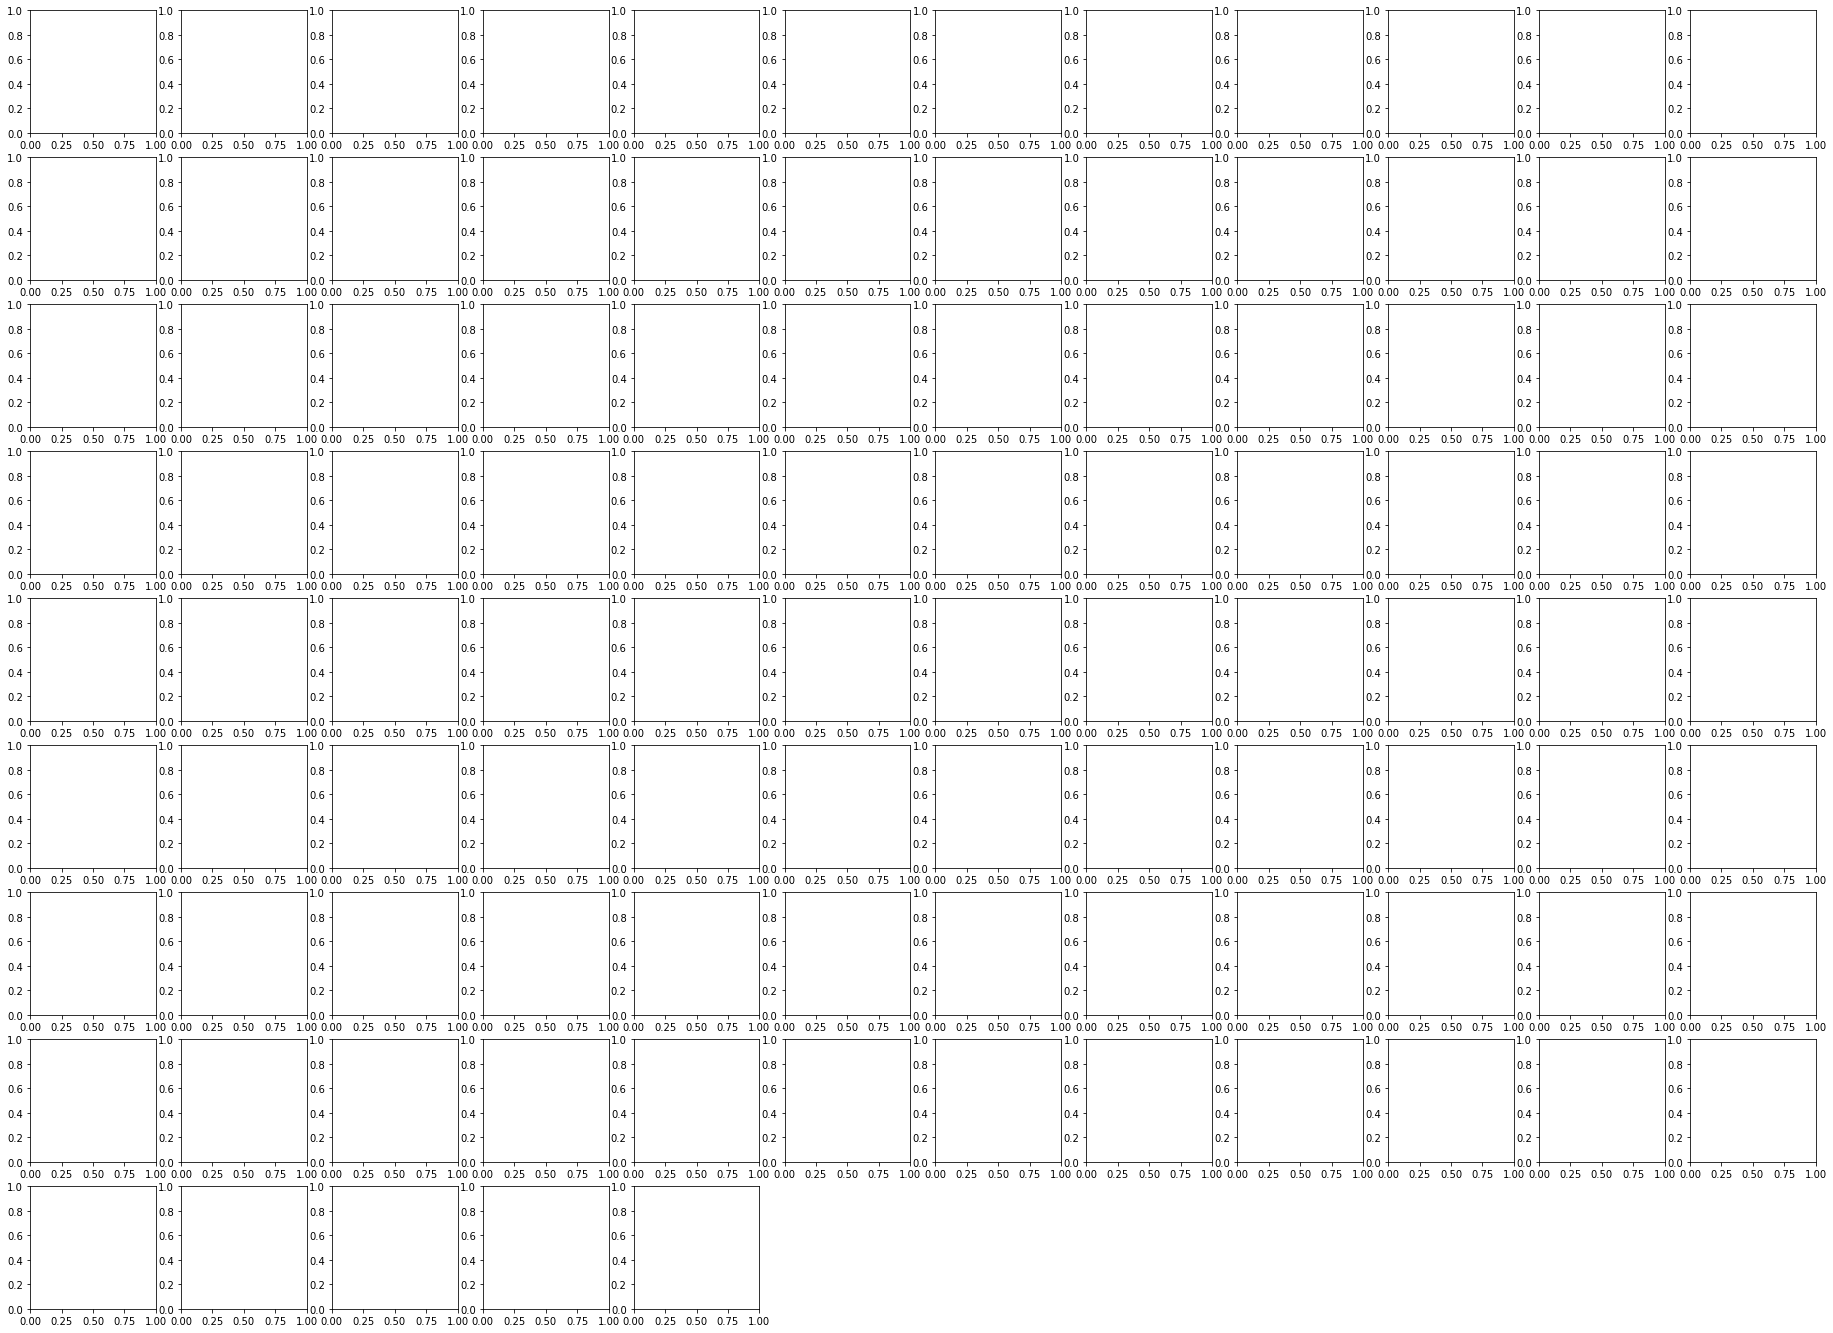

In [219]:
sx, sy = 192, 192

depth_images_for_display = []
sharpness_images_for_display = []
for view in tqdm(views_reprojected_source):
    image = clip_to_depth(
        view.to_pixels().depth, 
        view.to_pixels().depth, 
        depth_value=0.0)
    
    distances = clip_to_depth(
        view.to_pixels().signal, 
        view.to_pixels().depth, 
        depth_value=0.0)
    
    distances, offset = crop_around_center(distances, (sx, sy))
    sharpness_images_for_display.append(distances)
    
    depth_images_for_display.append(
        image[offset[0]:offset[0] + sy, offset[1]:offset[1] + sx])

    
display_depth_sharpness(
#     depth_images=depth_images_for_display,
    sharpness_images=sharpness_images_for_display,
    ncols=12,
    axes_size=(32, 32),
    bgcolor='white',
    max_sharpness=1.0)

In [434]:
config = {
    'verbose': False,
    'n_jobs': 24,
    'type': 'image',
    'distance_interpolation_threshold': 'auto',
    'nn_set_size': 8,
    'interp_ratio_thr': 0.0,
    'z_distance_threshold': 2.5,
}
mvs_interpolator = load_func_from_config(MVS_INTERPOLATORS, config)


{'image': <class 'sharpf.fusion.images.interpolators.MultiViewImage'>} {'verbose': False, 'n_jobs': 24, 'type': 'image', 'distance_interpolation_threshold': 'auto', 'nn_set_size': 8, 'interp_ratio_thr': 0.0, 'z_distance_threshold': 2.5}


In [435]:
list_predictions, list_indexes_in_whole, list_points = mvs_interpolator(views_predicted)

Interpolating: 0it [00:00, ?it/s]32/1077 [00:00<00:00, 4307.44it/s]
Interpolating: 100%|██████████| 16/16 [00:00<00:00, 1073.62it/s]t/s]
Interpolating: 0it [00:00, ?it/s]
Interpolating: 100%|██████████| 104/104 [00:00<00:00, 4924.84it/s]
Interpolating: 0it [00:00, ?it/s]
Interpolating: 100%|██████████| 79/79 [00:00<00:00, 481.69it/s]
Interpolating: 0it [00:00, ?it/s]
Interpolating: 100%|██████████| 158/158 [00:00<00:00, 992.36it/s]]
Interpolating: 0it [00:00, ?it/s]
Interpolating: 100%|██████████| 38/38 [00:00<00:00, 748.88it/s]t/s]
Interpolating: 0it [00:00, ?it/s]/93 [00:00<?, ?it/s]
Interpolating: 100%|██████████| 278/278 [00:00<00:00, 3925.10it/s]]
Interpolating: 0it [00:00, ?it/s]/13 [00:00<?, ?it/s]
Interpolating: 100%|██████████| 93/93 [00:00<00:00, 1177.27it/s]] ]
Interpolating: 0it [00:00, ?it/s]23/1229 [00:00<00:00, 4225.67it/s]
Interpolating: 100%|██████████| 783/783 [00:00<00:00, 1861.72it/s]s]
Interpolating: 0it [00:00, ?it/s]21/906 [00:01<00:00, 649.67it/s]s]
Interpolatin

Interpolating: 100%|██████████| 2507/2507 [00:00<00:00, 6961.61it/s]


In [436]:
combiner = combiners.MinPredictionsCombiner()
# combiner = combiners.TruncatedAvgPredictionsCombiner(func=np.min)
# combiner = combiners.SmoothingCombiner(
#     combiner=combiners.MinPredictionsCombiner(),
#     smoother=smoothers.RobustLocalLinearFit(
#         lm.HuberRegressor(epsilon=4., alpha=1.),
#         n_jobs=16))
    
n_points = np.max(np.concatenate(list_indexes_in_whole)) + 1
fused_points_pred, fused_distances_pred, fusion_variants_pred = combiner(
    n_points,
    list_predictions,
    list_indexes_in_whole,
    list_points,
    max_distance=2.5)

144it [00:00, 2782.75it/s]


In [437]:
_ = display_sharpness(
    samples=fused_points_pred,
    samples_distances=fused_distances_pred,
    samples_psize=0.5,
    cmap=k3d.colormaps.matplotlib_color_maps.plasma_r,
    max_distance_to_feature=0.5
)

Output()

In [232]:

nn_distances, nn_indexes = cKDTree(fused_points_pred, leafsize=16).query(fused_points_pred[10000], k=1000)


In [373]:
# from scipy.spatial.ckdtree import cKDTree

# nn_distances, _ = cKDTree(fused_points_pred, leafsize=16).query(fused_points_pred, k=2, n_jobs=10)
# r = np.mean(nn_distances[:, 1])
# fused_distances_pred_thr = (fused_distances_pred > r * 1.5).astype(float)


_ = display_sharpness(
    samples=fused_points_pred[nn_indexes],
    samples_distances=fused_distances_pred[nn_indexes],
    samples_psize=0.5,
    cmap=k3d.colormaps.matplotlib_color_maps.plasma_r,
    max_distance_to_feature=1.0
)

Output()

In [250]:

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import sklearn.linear_model as lm



def local_linear_fit_with_pipe(X, y):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
#         ('pca', PCA(n_components=2)),
#         ('feat', PolynomialFeatures(2)),
        ('reg', lm.HuberRegressor(epsilon=4., alpha=1., max_iter=1000))])
    try:
        y_pred = pipe.fit(X, y).predict(X)
    except ValueError:
        y_pred = None
    return y_pred

In [342]:
nn_distances, nn_indexes = cKDTree(fused_points_pred, leafsize=16).query(fused_points_pred[10000], k=1000)
x, y = fused_points_pred[nn_indexes].copy(), fused_distances_pred[nn_indexes].copy()
x_trans = StandardScaler().fit_transform(x)
y_trans = StandardScaler().fit_transform(np.atleast_2d(y).T)
# x_trans = PCA(n_components=2).fit_transform(
#     StandardScaler().fit_transform(x))

In [330]:
_, nn_indexes_local = cKDTree(x_trans, leafsize=16).query(x_trans, k=40)

In [356]:
vectors = []
for i, (xx, yy) in enumerate(zip(x_trans, y_trans)):
    x_local = np.concatenate((
        [np.concatenate((yy, xx))], 
        np.hstack((y_trans[nn_indexes_local[i]], x_trans[nn_indexes_local[i]]))
    ))
    vectors.append(PCA(n_components=3).fit(x_local).components_)

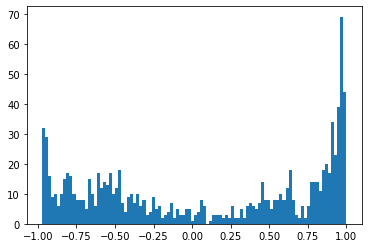

In [371]:
_=plt.hist(np.array([v1 for v1, v2, v3 in vectors])[:,0], bins=100)

In [361]:
_ = display_sharpness(
    samples=x,
    samples_distances=y,
    directions=np.array([v1 for v1, v2, v3 in vectors]),
    samples_psize=0.5,
    cmap=k3d.colormaps.matplotlib_color_maps.plasma_r,
    max_distance_to_feature=0.5,
    sharp_vert=x[reg.inlier_mask_],
)

Vectors(colors=array([], dtype=uint32), head_color=255, id=139653605332248, line_width=0.0025, model_matrix=array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32), origin_color=255, origins=array([[ -94.132935,  -99.30426 ,  -43.795265],
       [ -94.126015,  -99.35402 ,  -44.101124],
       [ -94.05756 ,  -99.60527 ,  -43.66604 ],
       ...,
       [ -97.17787 , -101.95398 ,  -46.40692 ],
       [ -93.87804 ,  -95.02172 ,  -41.62356 ],
       [ -94.60818 ,  -97.14228 ,  -48.067326]], dtype=float32), type='Vectors', vectors=array([[-0.37465787,  0.2188036 ,  0.20139427, -0.02484014],
       [-0.3077403 ,  0.29460114,  0.22880283,  0.03421682],
       [-0.39640212,  0.2295561 ,  0.13262261,  0.08942018],
       ...,
       [-0.16575018,  0.11957155,  0.36598468, -0.52839416],
       [ 0.09892455, -0.29880357,  0.09058417, -0.1762179 ],
       [ 0.15356167, -0.07016631, -0.09967088, -0.02443361]],
      dtype=float32), visible

Output()

In [307]:
reg = lm.RANSACRegressor(
    base_estimator=lm.LinearRegression(),
    min_samples=0.1,
    residual_threshold=0.1,
)

In [308]:
y_pred = reg.fit(x_trans, y).predict(x_trans)

In [309]:
reg.inlier_mask_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True, False,  True, False,  True, False, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True, False,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [311]:
_ = display_sharpness(
    samples=x,
    samples_distances=y_pred,
    samples_psize=0.5,
    cmap=k3d.colormaps.matplotlib_color_maps.plasma_r,
    max_distance_to_feature=0.5,
    sharp_vert=x[reg.inlier_mask_]
)

Output()

In [395]:
# Translation in python of the Matlab implementation of Mathieu Andreux and
# Michel Blancard, of the algorithm described in
# "Mixtures of Probabilistic Principal Component Analysers",
# Michael E. Tipping and Christopher M. Bishop, Neural Computation 11(2),
# pp 443–482, MIT Press, 1999


import numpy as np


def initialization_kmeans(X, p, q, variance_level=None):
    """
    X : dataset
    p : number of clusters
    q : dimension of the latent space
    variance_level

    pi : proportions of clusters
    mu : centers of the clusters in the observation space
    W : latent to observation matricies
    sigma2 : noise
    """

    N, d = X.shape

    # initialization
    init_centers = np.random.randint(0, N, p)
    while (len(np.unique(init_centers)) != p):
        init_centers = np.random.randint(0, N, p)

    mu = X[init_centers, :]
    distance_square = np.zeros((N, p))
    clusters = np.zeros(N, dtype=np.int32)

    D_old = -2
    D = -1

    while(D_old != D):
        D_old = D

        # assign clusters
        for c in range(p):
            distance_square[:, c] = np.power(X - mu[c, :], 2).sum(1)
        clusters = np.argmin(distance_square, axis=1)

        # compute distortion
        distmin = distance_square[range(N), clusters]
        D = distmin.sum()

        # compute new centers
        for c in range(p):
            mu[c, :] = X[clusters == c, :].mean(0)

    #for c in range(p):
    #    plt.scatter(X[clusters == c, 0], X[clusters == c, 1], c=np.random.rand(3,1))

    # parameter initialization
    pi = np.zeros(p)
    W = np.zeros((p, d, q))
    sigma2 = np.zeros(p)
    for c in range(p):
        if variance_level:
            W[c, :, :] = variance_level * np.random.randn(d, q)
        else:
            W[c, :, :] = np.random.randn(d, q)

        pi[c] = (clusters == c).sum() / N
        if variance_level:
            sigma2[c] = np.abs((variance_level/10) * np.random.randn())
        else:
            sigma2[c] = (distmin[clusters == c]).mean() / d

    return pi, mu, W, sigma2, clusters


def mppca_gem(X, pi, mu, W, sigma2, niter):
    N, d = X.shape
    p = len(sigma2)
    _, q = W[0].shape

    sigma2hist = np.zeros((p, niter))
    M = np.zeros((p, q, q))
    Minv = np.zeros((p, q, q))
    Cinv = np.zeros((p, d, d))
    logR = np.zeros((N, p))
    R = np.zeros((N, p))
    M[:] = 0.
    Minv[:] = 0.
    Cinv[:] = 0.

    L = np.zeros(niter)
    for i in range(niter):
        print('.', end='')
        for c in range(p):
            sigma2hist[c, i] = sigma2[c]

            # M
            M[c, :, :] = sigma2[c]*np.eye(q) + np.dot(W[c, :, :].T, W[c, :, :])
            Minv[c, :, :] = np.linalg.inv(M[c, :, :])

            # Cinv
            Cinv[c, :, :] = (np.eye(d)
                - np.dot(np.dot(W[c, :, :], Minv[c, :, :]), W[c, :, :].T)
                ) / sigma2[c]

            # R_ni
            deviation_from_center = X - mu[c, :]
            logR[:, c] = ( np.log(pi[c])
                + 0.5*np.log(
                    np.linalg.det(
                        np.eye(d) - np.dot(np.dot(W[c, :, :], Minv[c, :, :]), W[c, :, :].T)
                    )
                )
                - 0.5*d*np.log(sigma2[c])
                - 0.5*(deviation_from_center * np.dot(deviation_from_center, Cinv[c, :, :].T)).sum(1)
                )

        myMax = logR.max(axis=1).reshape((N, 1))
        L[i] = (
            (myMax.ravel() + np.log(np.exp(logR - myMax).sum(axis=1))).sum(axis=0)
            - N*d*np.log(2*3.141593)/2.
            )

        logR = logR - myMax - np.reshape(np.log(np.exp(logR - myMax).sum(axis=1)), (N, 1))

        myMax = logR.max(axis=0)
        logpi = myMax + np.log(np.exp(logR - myMax).sum(axis=0)) - np.log(N)
        logpi = logpi.T
        pi = np.exp(logpi)
        R = np.exp(logR)
        for c in range(p):
            mu[c, :] = (R[:, c].reshape((N, 1)) * X).sum(axis=0) / R[:, c].sum()
            deviation_from_center = X - mu[c, :].reshape((1, d))

            SW = ( (1/(pi[c]*N))
                * np.dot((R[:, c].reshape((N, 1)) * deviation_from_center).T,
                    np.dot(deviation_from_center, W[c, :, :]))
                )

            Wnew = np.dot(SW, np.linalg.inv(sigma2[c]*np.eye(q) + np.dot(np.dot(Minv[c, :, :], W[c, :, :].T), SW)))

            sigma2[c] = (1/d) * (
                (R[:, c].reshape(N, 1) * np.power(deviation_from_center, 2)).sum()
                /
                (N*pi[c])
                -
                np.trace(np.dot(np.dot(SW, Minv[c, :, :]), Wnew.T))
                )

            W[c, :, :] = Wnew

    return pi, mu, W, sigma2, R, L, sigma2hist


def mppca_predict(X, pi, mu, W, sigma2):
    N, d = X.shape
    p = len(sigma2)
    _, q = W[0].shape

    M = np.zeros((p, q, q))
    Minv = np.zeros((p, q, q))
    Cinv = np.zeros((p, d, d))
    logR = np.zeros((N, p))
    R = np.zeros((N, p))

    for c in range(p):
        # M
        M[c, :, :] = sigma2[c] * np.eye(q) + np.dot(W[c, :, :].T, W[c, :, :])
        Minv[c, :, :] = np.linalg.inv(M[c, :, :])

        # Cinv
        Cinv[c, :, :] = (np.eye(d)
            - np.dot(np.dot(W[c, :, :], Minv[c, :, :]), W[c, :, :].T)
            ) / sigma2[c]

        # R_ni
        deviation_from_center = X - mu[c, :]
        logR[:, c] = ( np.log(pi[c])
            + 0.5*np.log(
                np.linalg.det(
                    np.eye(d) - np.dot(np.dot(W[c, :, :], Minv[c, :, :]), W[c, :, :].T)
                )
            )
            - 0.5*d*np.log(sigma2[c])
            - 0.5*(deviation_from_center * np.dot(deviation_from_center, Cinv[c, :, :].T)).sum(1)
            )

    myMax = logR.max(axis=1).reshape((N, 1))
    logR = logR - myMax - np.reshape(np.log(np.exp(logR - myMax).sum(axis=1)), (N, 1))
    R = np.exp(logR)

    return R

(slice(512, 1024, None), slice(768, 1280, None))
[9.026981   9.79376793 9.79759991 ... 9.45937991 9.42386091 8.18346202]


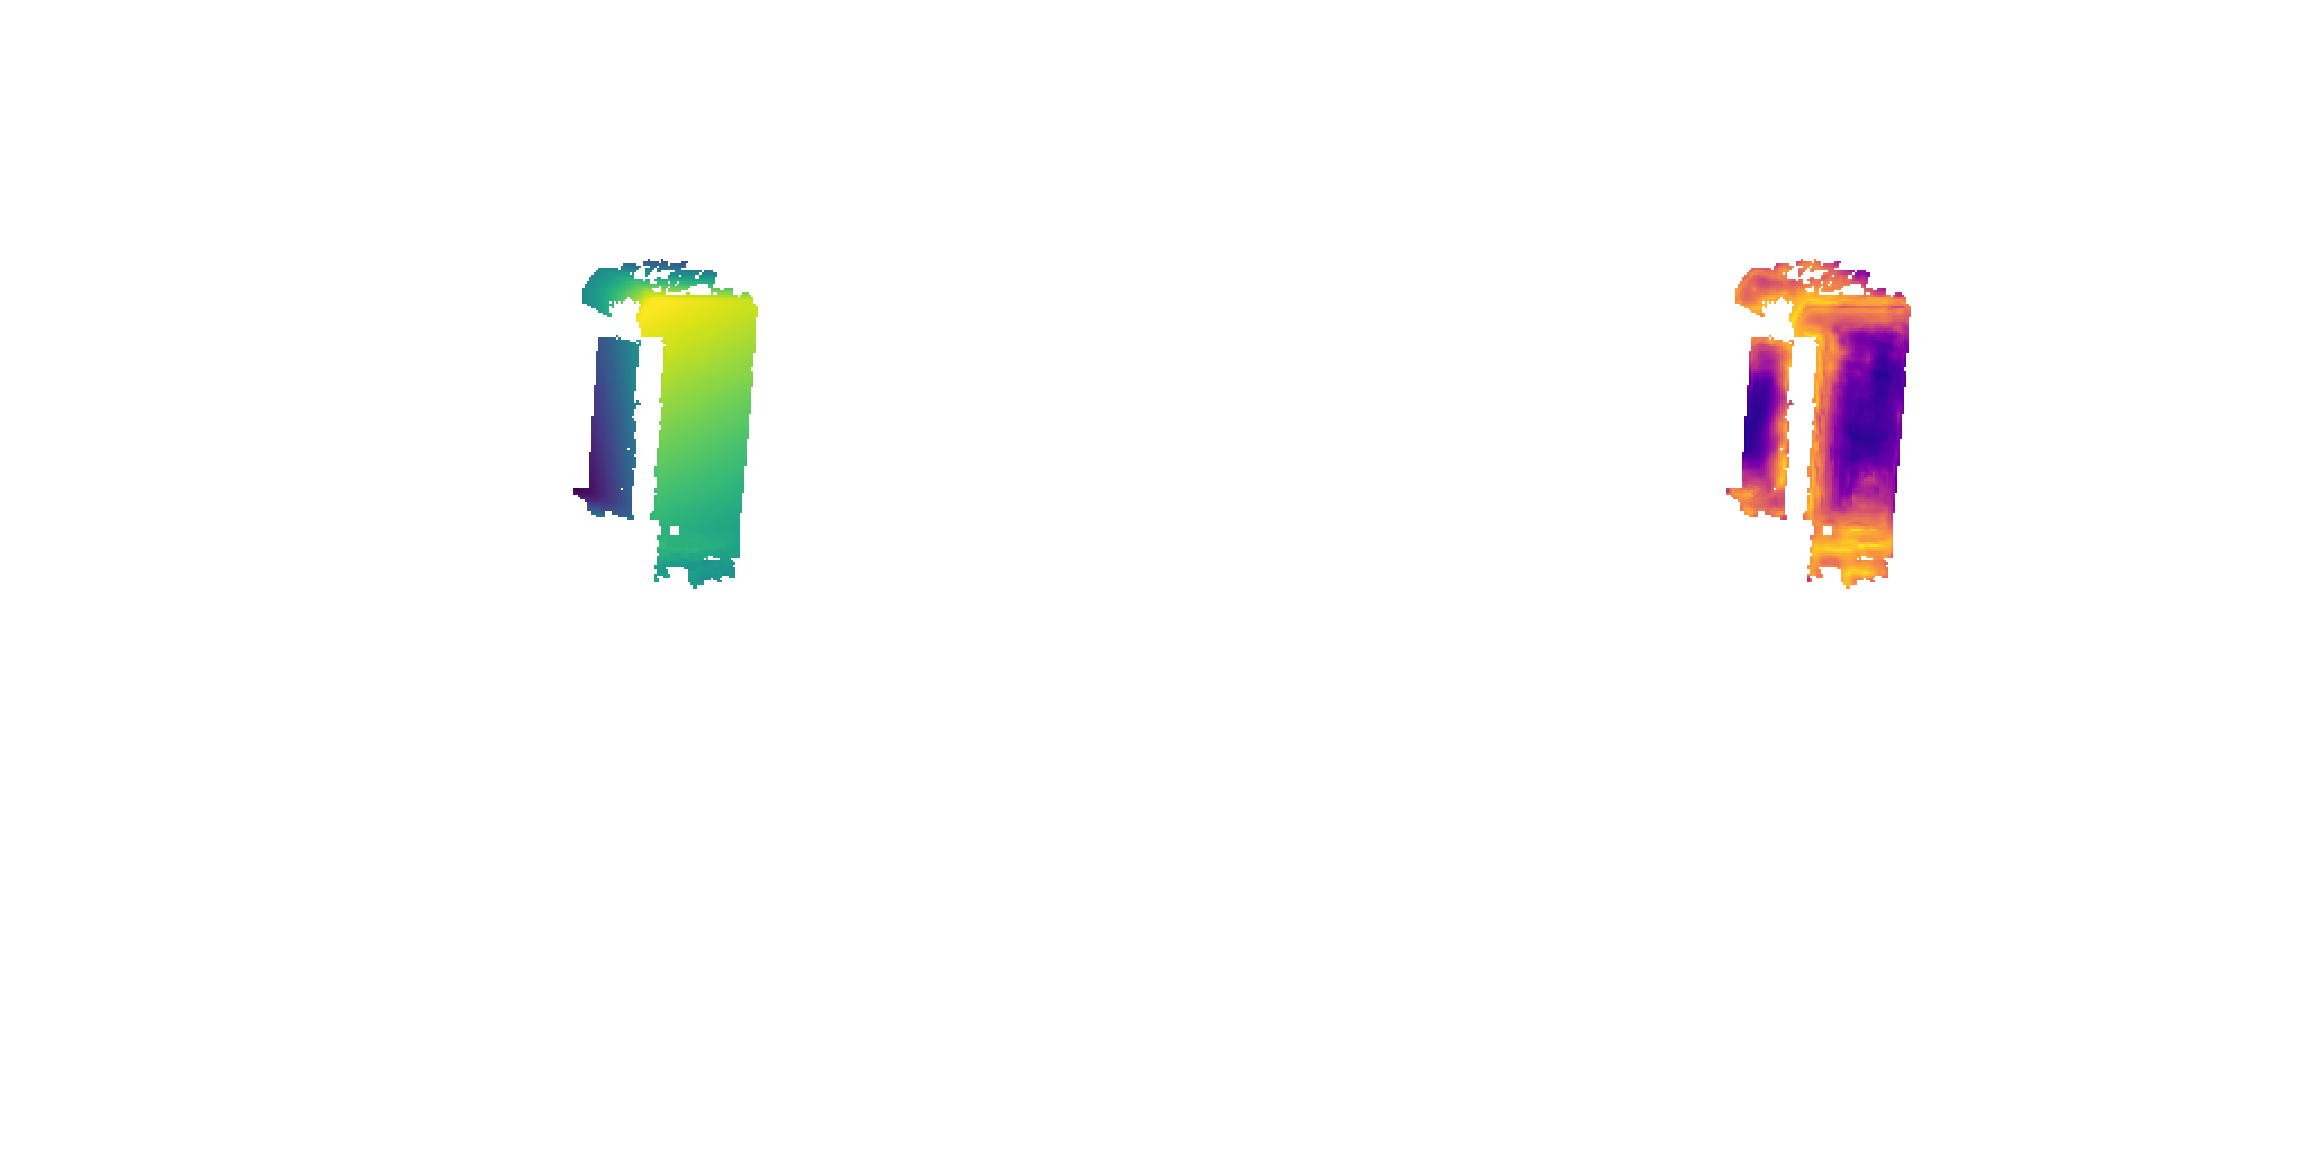

In [455]:

def sharpness_with_depth_background(
        sharpness_image,
        depth_image,
        depth_bg_value=1.0,
        sharpness_bg_value=0.0,
):
    image = sharpness_image.copy()
    print(image[image!=sharpness_bg_value])
    image[depth_image == depth_bg_value] = sharpness_bg_value
    return image



AnnotatedImageIO = io_struct.HDF5IO(
        {'image': io_struct.Float64('image'),
         'distances': io_struct.Float64('distances')},
        len_label='distances',
        compression='lzf')

d = Hdf5File(
'/logs/100side_folder_images__aligninf_partmesh_whole__predictions.hdf5',
io=AnnotatedImageIO,
preload=PreloadTypes.LAZY,
labels='*')

images = [dd['image'] for dd in d]
distances = [dd['distances'] for dd in d]

rx, ry = rv_utils.RV_SPECTRUM_CAM_RESOLUTION
sx, sy = 512, 512
slices = slice(ry // 2 - sy // 2, ry // 2 + sy // 2),\
         slice(rx // 2 - sx // 2, rx // 2 + sx // 2)
print(slices)

depth_images_for_display = [image[slices] for image in images]
sharpness_images_for_display = [d[slices] for d in distances]


display_depth_sharpness(
    depth_images=depth_images_for_display[0],
    sharpness_images=sharpness_with_depth_background(
        sharpness_images_for_display[0],
        depth_images_for_display[0], 0.0, 10.0),
    ncols=1,
    axes_size=(16, 16),
    bgcolor='white',
    max_sharpness=10.0,
    sharpness_bg_value=10.0)